In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# OM theme colors

darkblueteal = '#0c4d6c'
green = '#217a3a'
redorange = '#f55b23'
lightblue = '#94c4eb'
gray = '#6b6e70'
yellowmustard = '#f4bd44'
darkgray = '#444444'
purple = '#8c564b'
burntorange = '#b84013'
lightgreen = '#83c28c'

In [112]:
def compare_regions_component_over_time(component_name, regions, year_start=1990, year_end=2023, annotate_every=10):
    """
    Compare a single component across multiple regions from year_start to year_end using a grouped bar chart.

    Parameters:
    - component_name (str): One of 'CO₂ Emissions', 'Population', 'GDP per capita',
      'Energy intensity', 'Carbon intensity', or 'Kaya Identity'.
    - regions (list[str]): Regions/countries to include (4 or more allowed).
    - year_start (int): Start year (default 1990)
    - year_end (int): End year (default 2023)
    - annotate_every (int): Add numeric labels every Nth year to reduce clutter.
    """
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Column mapping in df_filtered
    components = {
        'CO₂ Emissions': 'Annual CO₂ emissions',
        'Population': 'Population (historical)',
        'GDP per capita': 'GDP per capita',
        'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
        'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)',
        'Kaya Identity': 'Kaya Identity'
    }

    unit_labels = {
        'CO₂ Emissions': 'CO₂ Emissions',
        'Population': 'Population (billions)',
        'GDP per capita': 'GDP per Capita ($)',
        'Energy intensity': 'Energy Intensity (kWh/$ GDP)',
        'Carbon intensity': 'Carbon Intensity (kg CO₂/kWh)',
        'Kaya Identity': 'Kaya Identity'
    }
    color_map = {
        'CO₂ Emissions': gray,
        'Population': green,
        'GDP per capita': lightgreen,
        'Energy intensity': '#99b6be',
        'Carbon intensity': burntorange
    }

    if component_name not in components:
        print("Unknown component. Choose one of:")
        print(list(components.keys()))
        return

    if 'df_filtered' not in globals():
        raise RuntimeError("df_filtered is not defined in this notebook scope.")

    col = components[component_name]
    df_scope = df_filtered[(df_filtered['Year'] >= year_start) & (df_filtered['Year'] <= year_end)].copy()
    
    # Add EU-27 data if needed
    if 'European Union (27)' in regions:
        eu27_data = calculate_eu27_data(df_filtered, year_start, year_end)
        if len(eu27_data) > 0:
            df_scope = pd.concat([df_scope, eu27_data], ignore_index=True)

    # Build candidate years at 5-year intervals, plus latest available year; include only years where any region has data
    # years_full = [y for y in range(year_start, year_end + 1) if (y - year_start) % 5 == 0]
    years_full = [y for y in range(year_start, year_end + 1) if (y - year_start) % 10 == 0]
    latest_avail_year = int(min(year_end, df_scope['Year'].max()))
    if latest_avail_year not in years_full:
        years_full.append(latest_avail_year)
        years_full = sorted(years_full)
    years = []
    for y in years_full:
        has_any = False
        for r in regions:
            sub = df_scope[(df_scope['Entity'] == r) & (df_scope['Year'] == y)]
            if len(sub) > 0 and col in sub.columns and not pd.isna(sub.iloc[-1][col]):
                has_any = True
                break
        if has_any:
            years.append(y)

    if len(years) == 0:
        print(f"No data available for {component_name} between {year_start}-{year_end} for the selected regions.")
        return

    indices = np.arange(len(years))
    n_regions = len(regions)
    bar_width = min(0.8 / max(1, n_regions), 0.25)

    palette = [green, lightgreen, '#99b6be', burntorange]

    # Figure size scales with years
    fig_width = min(max(12, 0.5 * len(years)), 26)
    plt.figure(figsize=(fig_width, 12))

    for i, region in enumerate(regions):
        offset = (i - (n_regions - 1) / 2) * bar_width
        vals = []
        for y in years:
            sub = df_scope[(df_scope['Entity'] == region) & (df_scope['Year'] == y)]
            if len(sub) == 0 or col not in sub.columns:
                vals.append(np.nan)
            else:
                try:
                    vals.append(float(sub.iloc[-1][col]))
                except Exception:
                    vals.append(np.nan)

        vals = np.array(vals, dtype=float)
        mask = ~np.isnan(vals)
        x_positions = indices[mask] + offset
        bars = plt.bar(x_positions, vals[mask], width=bar_width, color=palette[i],
                       edgecolor='black', linewidth=0.5, alpha=0.85, label=region)

        # # Annotate every Nth bar for this region
        # if annotate_every is not None and annotate_every > 0:
        #     for (x_pos, v, idx_year) in zip(x_positions, vals[mask], np.where(mask)[0]):
        #         if (years[idx_year] - years[0]) % annotate_every == 0:
        #             plt.text(x_pos, v, f"{v:,.2f}", ha='center', va='bottom', fontsize=8)

    # X-axis labels every 5 years to reduce clutter
    tick_idx = [i for i, y in enumerate(years) if (y - years[0]) % 5 == 0 or i in (0, len(years) - 1)]
    tick_positions = indices[tick_idx]
    tick_labels = [years[i] for i in tick_idx]

    plt.xticks(tick_positions, tick_labels, rotation=0)
    plt.xlabel('Year')
    plt.ylabel(unit_labels.get(component_name, component_name))
    plt.title(f"{component_name} across {years[0]}-{years[-1]}")
    plt.grid(axis='y', alpha=0.3)
    plt.legend( ncols=min(4, n_regions), frameon=False)
    plt.tight_layout()
    plt.show()


In [90]:
def create_kaya_bar_charts(region_name):
    """
    Create bar charts for each Kaya identity component for a selected region,
    plotting only every 5 years plus the latest available year.

    Parameters:
    region_name (str): Name of the region/country to analyze
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Filter data for the selected region
    region_data = df_filtered[df_filtered['Entity'] == region_name].copy()

    if len(region_data) == 0:
        print(f"No data available for {region_name}")
        return

    # Sort by year
    region_data = region_data.sort_values('Year')

    # Define the components and their corresponding columns
    components = {
        'Population': 'Population (historical)',
        'GDP per capita': 'GDP per capita',
        'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
        'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)',
        'CO₂ Emissions': 'Annual CO₂ emissions'
    }

    unit_labels = {
        'Population': 'Population (billions)',
        'GDP per capita': 'GDP per Capita ($)',
        'Energy intensity': 'Energy Intensity (kWh/$ GDP)',
        'Carbon intensity': 'Carbon Intensity (kg CO₂/kWh)',
        'CO₂ Emissions': 'CO₂ Emissions (tonnes)'
    }

    # Create subplots (3x2 layout for 5 components)
    fig, axes = plt.subplots(3, 2, figsize=(30, 30))
    # fig, axes = plt.subplots(3, 2, figsize=(30, 40))
    fig.suptitle(f'Kaya Identity Components: {region_name} (1990-2023)', fontsize=30, fontweight='bold')

    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Hide the 6th subplot since we only have 5 components
    axes[5].set_visible(False)

    for idx, (component_name, column_name) in enumerate(components.items()):
        ax = axes[idx]

        # Get data for this component
        component_data = region_data[['Year', column_name]].dropna()
        if len(component_data) == 0:
            ax.text(0.5, 0.5, f'No data available\nfor {component_name}',
                    ha='center', va='center', transform=ax.transAxes, fontsize=24)
            ax.set_title(f'{component_name}', fontweight='bold')
            continue

        # Keep only 5-year steps from 1990 plus latest available year
        start_year = 1990
        end_year = 2023
        years_full = [y for y in range(start_year, end_year + 1) if (y - start_year) % 5 == 0]
        latest_year = int(component_data['Year'].max())
        if latest_year not in years_full:
            years_full.append(latest_year)
        years_selected = sorted(set(y for y in years_full if y in set(component_data['Year'].astype(int))))

        component_data = component_data[component_data['Year'].isin(years_selected)]

        # Create evenly spaced x-positions for bars
        x_positions = np.arange(len(component_data))
        
        # Create bar chart with gray color for CO₂ Emissions
        bar_color = 'gray' if component_name == 'CO₂ Emissions' else colors[component_name]
        bars = ax.bar(x_positions, component_data[column_name],
                      color=bar_color, alpha=0.7, edgecolor='black', linewidth=0.5)

        # Customize the plot
        ax.set_title(f'{component_name}', fontweight='bold', fontsize=28)
        ax.set_xlabel('Year', fontsize=24)
        ax.set_ylabel(f'{unit_labels[component_name]}', fontsize=24)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(component_data['Year'].astype(int))

        ax.tick_params(axis='x', labelsize=24)
        ax.tick_params(axis='y', labelsize=24)

        # Add grid
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars (every 10 years and the last one)
        for i, (x_pos, year, value) in enumerate(zip(x_positions, component_data['Year'], component_data[column_name])):
            if (year - years_selected[0]) % 10 == 0 or i == len(component_data) - 1:
                ax.text(x_pos, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)

        # Add trend line over the selected points
        if len(component_data) > 1:
            z = np.polyfit(x_positions, component_data[column_name], 1)
            p = np.poly1d(z)
            ax.plot(x_positions, p(x_positions),
                    "r--", alpha=0.8, linewidth=2, label='Trend')

    plt.tight_layout()
    plt.show()

    # Print summary statistics for selected years
    print(f"\nSummary Statistics for {region_name} (selected years):")
    print("=" * 50)

    for component_name, column_name in components.items():
        component_data = region_data[['Year', column_name]].dropna()
        years_full = [y for y in range(1990, 2023 + 1) if (y - 1990) % 5 == 0]
        latest_year = int(component_data['Year'].max()) if len(component_data) > 0 else 2023
        if latest_year not in years_full:
            years_full.append(latest_year)
        years_selected = sorted(set(y for y in years_full if y in set(component_data['Year'].astype(int))))
        component_data = component_data[component_data['Year'].isin(years_selected)][column_name].dropna()
        if len(component_data) > 0:
            print(f"\n{component_name}:")
            print(f"  • Start (first selected): {component_data.iloc[0]:.2f}")
            print(f"  • End (last selected): {component_data.iloc[-1]:.2f}")
            print(f"  • Change: {((component_data.iloc[-1] - component_data.iloc[0]) / component_data.iloc[0] * 100):.1f}%")
            print(f"  • Average: {component_data.mean():.2f}")
            print(f"  • Std Dev: {component_data.std():.2f}")


In [102]:
def calculate_eu27_data(df, year_start=1990, year_end=2023):
    """
    Calculate EU-27 aggregated data for all Kaya components.
    Returns a DataFrame with EU-27 data for the specified year range.
    """
    import pandas as pd
    import numpy as np
    
    # EU-27 countries list
    eu_27 = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
             'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 
             'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
             'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
    
    def weighted_mean(df, value_col, weight_col):
        vals = df[value_col]
        weights = df[weight_col]
        if weights.sum() == 0:
            return float('nan')
        return (vals * weights).sum() / weights.sum()
    
    # Filter EU-27 countries and year range
    eu_data = df[(df['Entity'].isin(eu_27)) & 
                 (df['Year'] >= year_start) & 
                 (df['Year'] <= year_end)].copy()
    
    if len(eu_data) == 0:
        return pd.DataFrame()
    
    # Aggregate by year
    grouped = []
    for year, group in eu_data.groupby('Year'):
        row = {
            'Entity': 'European Union (27)',
            'Year': year,
            'Annual CO₂ emissions': group['Annual CO₂ emissions'].sum(),
            'Population (historical)': group['Population (historical)'].sum(),
            'GDP per capita': weighted_mean(group, 'GDP per capita', 'Population (historical)'),
            'Primary energy consumption per GDP (kWh/$)': weighted_mean(group, 'Primary energy consumption per GDP (kWh/$)', 'GDP per capita'),
            'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)': weighted_mean(group, 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)', 'Primary energy consumption per GDP (kWh/$)')
        }
        
        # Calculate Kaya Identity: Pop × GDP/Pop × Energy/GDP × CO2/Energy
        if (not pd.isna(row['Population (historical)']) and 
            not pd.isna(row['GDP per capita']) and 
            not pd.isna(row['Primary energy consumption per GDP (kWh/$)']) and 
            not pd.isna(row['Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'])):
            row['Kaya Identity'] = (row['Population (historical)'] * 
                                  row['GDP per capita'] * 
                                  row['Primary energy consumption per GDP (kWh/$)'] * 
                                  row['Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'])
        else:
            row['Kaya Identity'] = float('nan')
            
        grouped.append(row)
    
    return pd.DataFrame(grouped)


In [ ]:
def compare_component_across_regions(component_name, regions, year=None, sort_desc=True, annotate=True):
    """
    Compare a single component across multiple regions as a bar chart.

    Parameters:
    - component_name (str): One of 'CO₂ Emissions', 'Population', 'GDP per capita',
      'Energy intensity', 'Carbon intensity', or 'Kaya Identity'.
    - regions (list[str]): Regions/countries to include (4 or more allowed).
    - year (int|None): Year to compare. If None, uses latest available year in df_filtered.
    - sort_desc (bool): Sort bars by value descending.
    - annotate (bool): Show value labels on bars.
    """
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Column mapping in df_filtered
    components = {
        'CO₂ Emissions': 'Annual CO₂ emissions',
        'Population': 'Population (historical)',
        'GDP per capita': 'GDP per capita',
        'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
        'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)',
        'Kaya Identity': 'Kaya Identity'
    }

    # Axis labels
    unit_labels = {
        'CO₂ Emissions': 'CO₂ Emissions',
        'Population': 'Population',
        'GDP per capita': 'GDP per Capita ($)',
        'Energy intensity': 'Energy Intensity (kWh/$ GDP)',
        'Carbon intensity': 'Carbon Intensity (kg CO₂/kWh)',
        'Kaya Identity': 'Kaya Identity (Pop × GDP/Pop × Energy/GDP × CO₂/Energy)'
    }

    if component_name not in components:
        print("Unknown component. Choose one of:")
        print(list(components.keys()))
        return

    if 'df_filtered' not in globals():
        raise RuntimeError("df_filtered is not defined in this notebook scope.")

    column_name = components[component_name]
    df_scope = df_filtered.copy()
    
    # Add EU-27 data if needed
    if 'European Union (27)' in regions:
        eu27_data = calculate_eu27_data(df_filtered, 1990, 2023)
        if len(eu27_data) > 0:
            df_scope = pd.concat([df_scope, eu27_data], ignore_index=True)

    if year is None:
        year = int(df_scope['Year'].max())

    values = []
    for region in regions:
        sub = df_scope[(df_scope['Entity'] == region) & (df_scope['Year'] == year)]
        if len(sub) == 0 or column_name not in sub.columns:
            values.append((region, np.nan))
        else:
            val = sub.iloc[-1][column_name]
            try:
                val = float(val)
            except Exception:
                val = np.nan
            values.append((region, val))

    # Drop regions with missing values for the selected year
    values = [(r, v) for r, v in values if not (isinstance(v, float) and np.isnan(v))]
    if len(values) == 0:
        print(f"No data available for {component_name} in {year} for the selected regions.")
        return

    if sort_desc:
        values.sort(key=lambda x: x[1], reverse=True)

    regions_sorted = [r for r, _ in values]
    vals_sorted = [v for _, v in values]

    palette = sns.color_palette('tab10', n_colors=max(10, len(regions_sorted)))
    colors = palette[:len(regions_sorted)]

    plt.figure(figsize=(max(10, 1.8 * len(regions_sorted)), 7))
    bars = plt.bar(regions_sorted, vals_sorted, color=colors, edgecolor='black', alpha=0.85)

    plt.ylabel(unit_labels.get(component_name, component_name))
    plt.xlabel('Region')
    plt.title(f"{component_name} by Region in {year}")
    plt.xticks(rotation=20, ha='right')
    plt.grid(axis='y', alpha=0.3)

    if annotate:
        for bar, value in zip(bars, vals_sorted):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:,.2f}",
                     ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


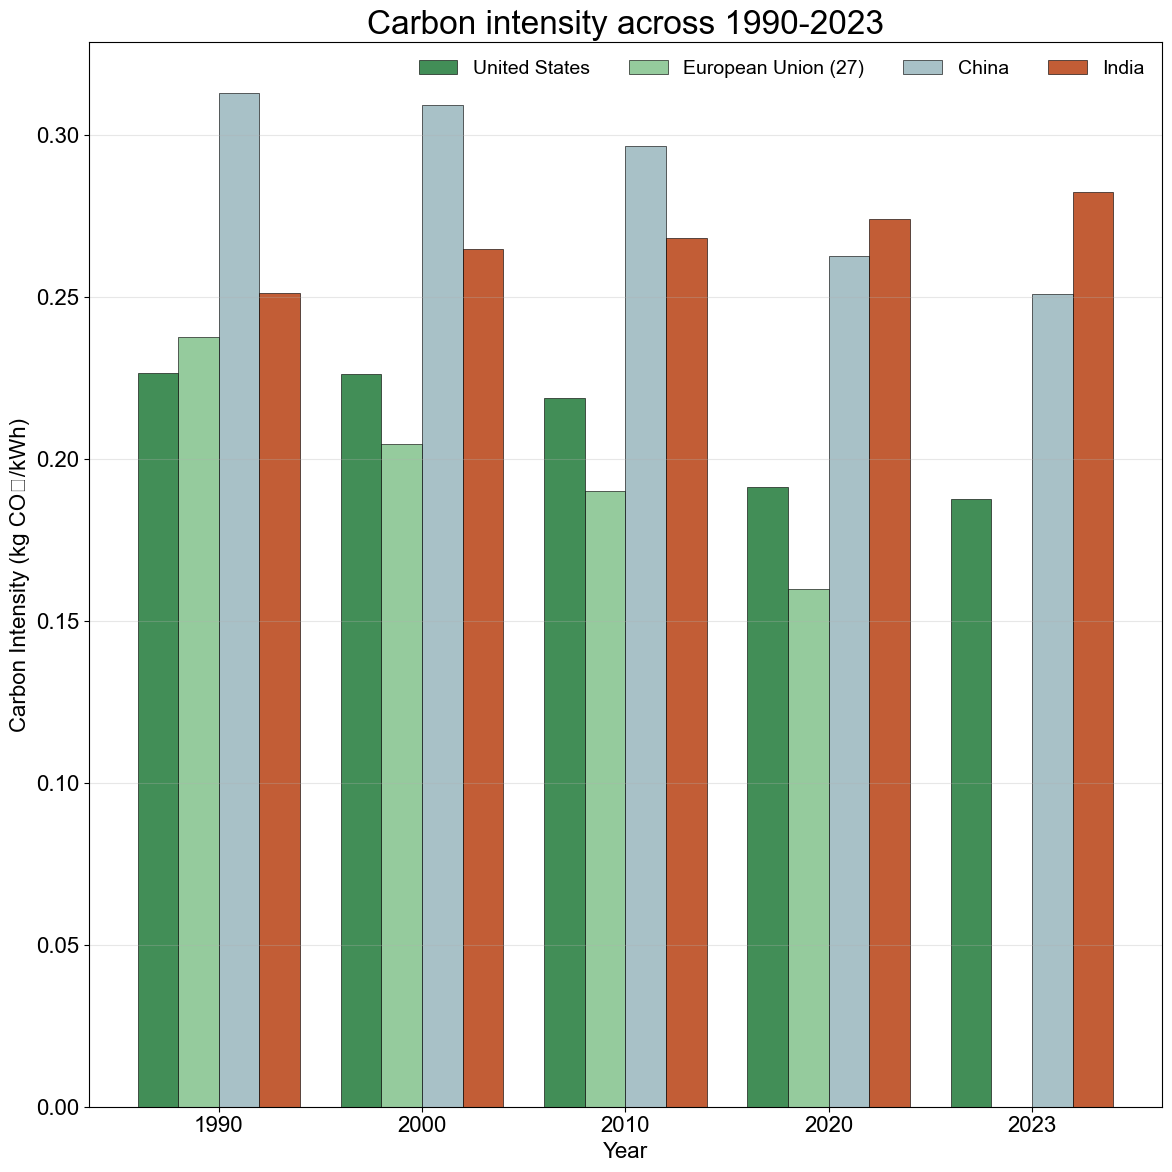

In [117]:
# Multi-year comparison with EU-27  
compare_regions_component_over_time('Carbon intensity',
    ['United States', 'European Union (27)','China', 'India'],
    year_start=1990, year_end=2023)


In [10]:
# Set the font family for all plot text
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' # or 'Helvetica'


# Set the font sizes globally
plt.rcParams['axes.titlesize'] = 24    # Font size for the plot title
plt.rcParams['axes.labelsize'] = 16   # Font size for x and y labels
plt.rcParams['legend.fontsize'] = 14   # Font size for the legend

# You can also set a base font size for all text
plt.rcParams['font.size'] = 16

In [4]:
# load data
df = pd.read_csv('/Users/amyliu/Documents/OpenMinds/OM/kaya-identity-co2_1/processed_kaya-identity-co2.csv')



/var/folders/gf/lf9k9p2j5j5fcvdnh2mcnqpc0000gn/T/ipykernel_55196/4141278816.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/amyliu/Documents/OpenMinds/OM/kaya-identity-co2_1/processed_kaya-identity-co2.csv')


In [5]:
df_filtered_year = df[df['Year'] >= 1990]

In [6]:
df_filtered_year.head()

,Entity,Code,Year,Annual CO₂ emissions,Primary energy consumption per GDP (kWh/$),GDP per capita,900793-annotations,Population (historical),Annual CO₂ emissions per unit energy (kg per kilowatt-hour),Annual CO₂ emissions per GDP (kg per international-$)
41,Afghanistan,AFG,1990,2024326.1,2.311106,963.00000,NaN,12045622.0,0.063767,0.154931
42,Afghanistan,AFG,1991,1914301.0,1.037307,881.17040,NaN,12238831.0,0.137692,0.158898
43,Afghanistan,AFG,1992,1482054.0,0.647377,843.87537,NaN,13278937.0,0.161659,0.116904
44,Afghanistan,AFG,1993,1486943.0,0.829252,578.40280,NaN,14943125.0,0.163304,0.151195
45,Afghanistan,AFG,1994,1453829.0,0.993833,428.42456,NaN,16250755.0,0.164910,0.183568


In [7]:
df_filtered_year['Entity'].unique()

array(['Afghanistan', 'Africa', 'Africa (GCP)', 'Africa (UN)',
       'Akrotiri and Dhekelia', 'Albania', 'Algeria', 'American Samoa',
       'Americas (UN)', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Asia (GCP)', 'Asia (UN)', 'Asia (excl. China and India)',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic',
       'Central America (GCP)', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curaca

In [8]:
entities = ['United States', 'China', 'India', 'European Union (27)', 'Middle East', 'Africa', 'South and Central America']


In [9]:
df_filtered_regions = df_filtered_year[df_filtered_year['Entity'].isin(['United States', 'China', 'India'])]

In [10]:
eu_27 = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

# df_eu_27 = df_filtered_year[df_filtered_year['Entity'].isin(eu_27)]

# df_eu_27['Entity'] = 'European Union (27)'

# df_filtered_regions = pd.concat([df_filtered_regions, df_eu_27], ignore_index=True)



middle_east = ['Bahrain', 'Iran', 'Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syria', 'United Arab Emirates', 'Yemen']

# df_me = df_filtered_year[df_filtered_year['Entity'].isin(middle_east)]

# df_me['Entity'] = 'Middle East'

# df_filtered_regions = pd.concat([df_filtered_regions, df_me], ignore_index=True)


africa = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cote Cote d\'Ivoire', 'Democratic Republic of Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

# df_africa = df_filtered_year[df_filtered_year['Entity'].isin(africa)]

# df_africa['Entity'] = 'Africa'

# df_filtered_regions = pd.concat([df_filtered_regions, df_africa], ignore_index=True)


americas = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Curacao', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Suriname', 'Trinidad and Tobago', 'Uruguay', 'Venezuela']

# df_americas = df_filtered_year[df_filtered_year['Entity'].isin(americas)]

# df_americas['Entity'] = 'South and Central America'

# df_filtered_regions = pd.concat([df_filtered_regions, df_americas], ignore_index=True)

region_map = {
    "European Union (27)": eu_27,
    "Middle East": middle_east,
    "Africa": africa,
    "Central and South America": americas
}




In [11]:
# --- 2. Helper function for weighted mean ---
def weighted_mean(df, value_col, weight_col):
    vals = df[value_col]
    weights = df[weight_col]
    if weights.sum() == 0:
        return float('nan')
    return (vals * weights).sum() / weights.sum()

# --- 3. Aggregation function for a region ---
def aggregate_region(df, region_name, country_list):
    region_df = df[df['Entity'].isin(country_list)]
    grouped = []
    for year, group in region_df.groupby('Year'):
        row = {
            'Entity': region_name,
            'Code': None,  # No ISO code for constructed region
            'Year': year,
            'Annual CO₂ emissions': group['Annual CO₂ emissions'].sum(),
            'Primary energy consumption per GDP (kWh/$)': weighted_mean(group, 'Primary energy consumption per GDP (kWh/$)', 'GDP per capita'),
            'GDP per capita': weighted_mean(group, 'GDP per capita', 'Population (historical)'),
            '900793-annotations': None,  # Or set to a region-specific note if you wish
            'Population (historical)': group['Population (historical)'].sum(),
            'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)': weighted_mean(group, 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)', 'Primary energy consumption per GDP (kWh/$)'),
            'Annual CO₂ emissions per GDP (kg per international-$)': weighted_mean(group, 'Annual CO₂ emissions per GDP (kg per international-$)', 'GDP per capita')
        }
        grouped.append(row)
    return pd.DataFrame(grouped)

# --- 4. Run aggregation for each region ---
region_dfs = []
for region, countries in region_map.items():
    region_dfs.append(aggregate_region(df, region, countries))

# --- 5. Combine all regional DataFrames ---
df_regions = pd.concat(region_dfs, ignore_index=True)

In [12]:
df_filtered_regions = pd.concat([df_filtered_regions, df_regions], ignore_index=True)
df_final = df_filtered_regions.drop(columns=['Code', '900793-annotations'])

In [13]:
df_final

,Entity,Year,Annual CO₂ emissions,Primary energy consumption per GDP (kWh/$),GDP per capita,Population (historical),Annual CO₂ emissions per unit energy (kg per kilowatt-hour),Annual CO₂ emissions per GDP (kg per international-$)
0,China,1990,2.484855e+09,2.345041,2982.000000,1.153583e+09,0.313023,0.734052
1,China,1991,2.606096e+09,2.376100,3051.315200,1.170788e+09,0.312571,0.742700
2,China,1992,2.730788e+09,2.336517,3227.744100,1.184574e+09,0.311247,0.727233
3,China,1993,2.921651e+09,2.292110,3506.480000,1.197309e+09,0.308920,0.708078
4,China,1994,3.103739e+09,2.263882,3730.164000,1.209003e+09,0.308866,0.699237
...,...,...,...,...,...,...,...,...
1937,Central and South America,2019,1.252504e+09,1.483443,13077.471427,5.091378e+08,0.181398,0.278381
1938,Central and South America,2020,1.123360e+09,1.397414,12084.027287,5.126421e+08,0.174594,0.260016
1939,Central and South America,2021,1.239688e+09,1.393038,12882.668002,5.155437e+08,0.177888,0.263053
1940,Central and South America,2022,1.255496e+09,1.389245,13302.563076,5.184880e+08,0.097432,0.255816


/var/folders/gf/lf9k9p2j5j5fcvdnh2mcnqpc0000gn/T/ipykernel_55196/1526467809.py:85: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/Users/amyliu/Documents/OpenMinds/OM/om-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


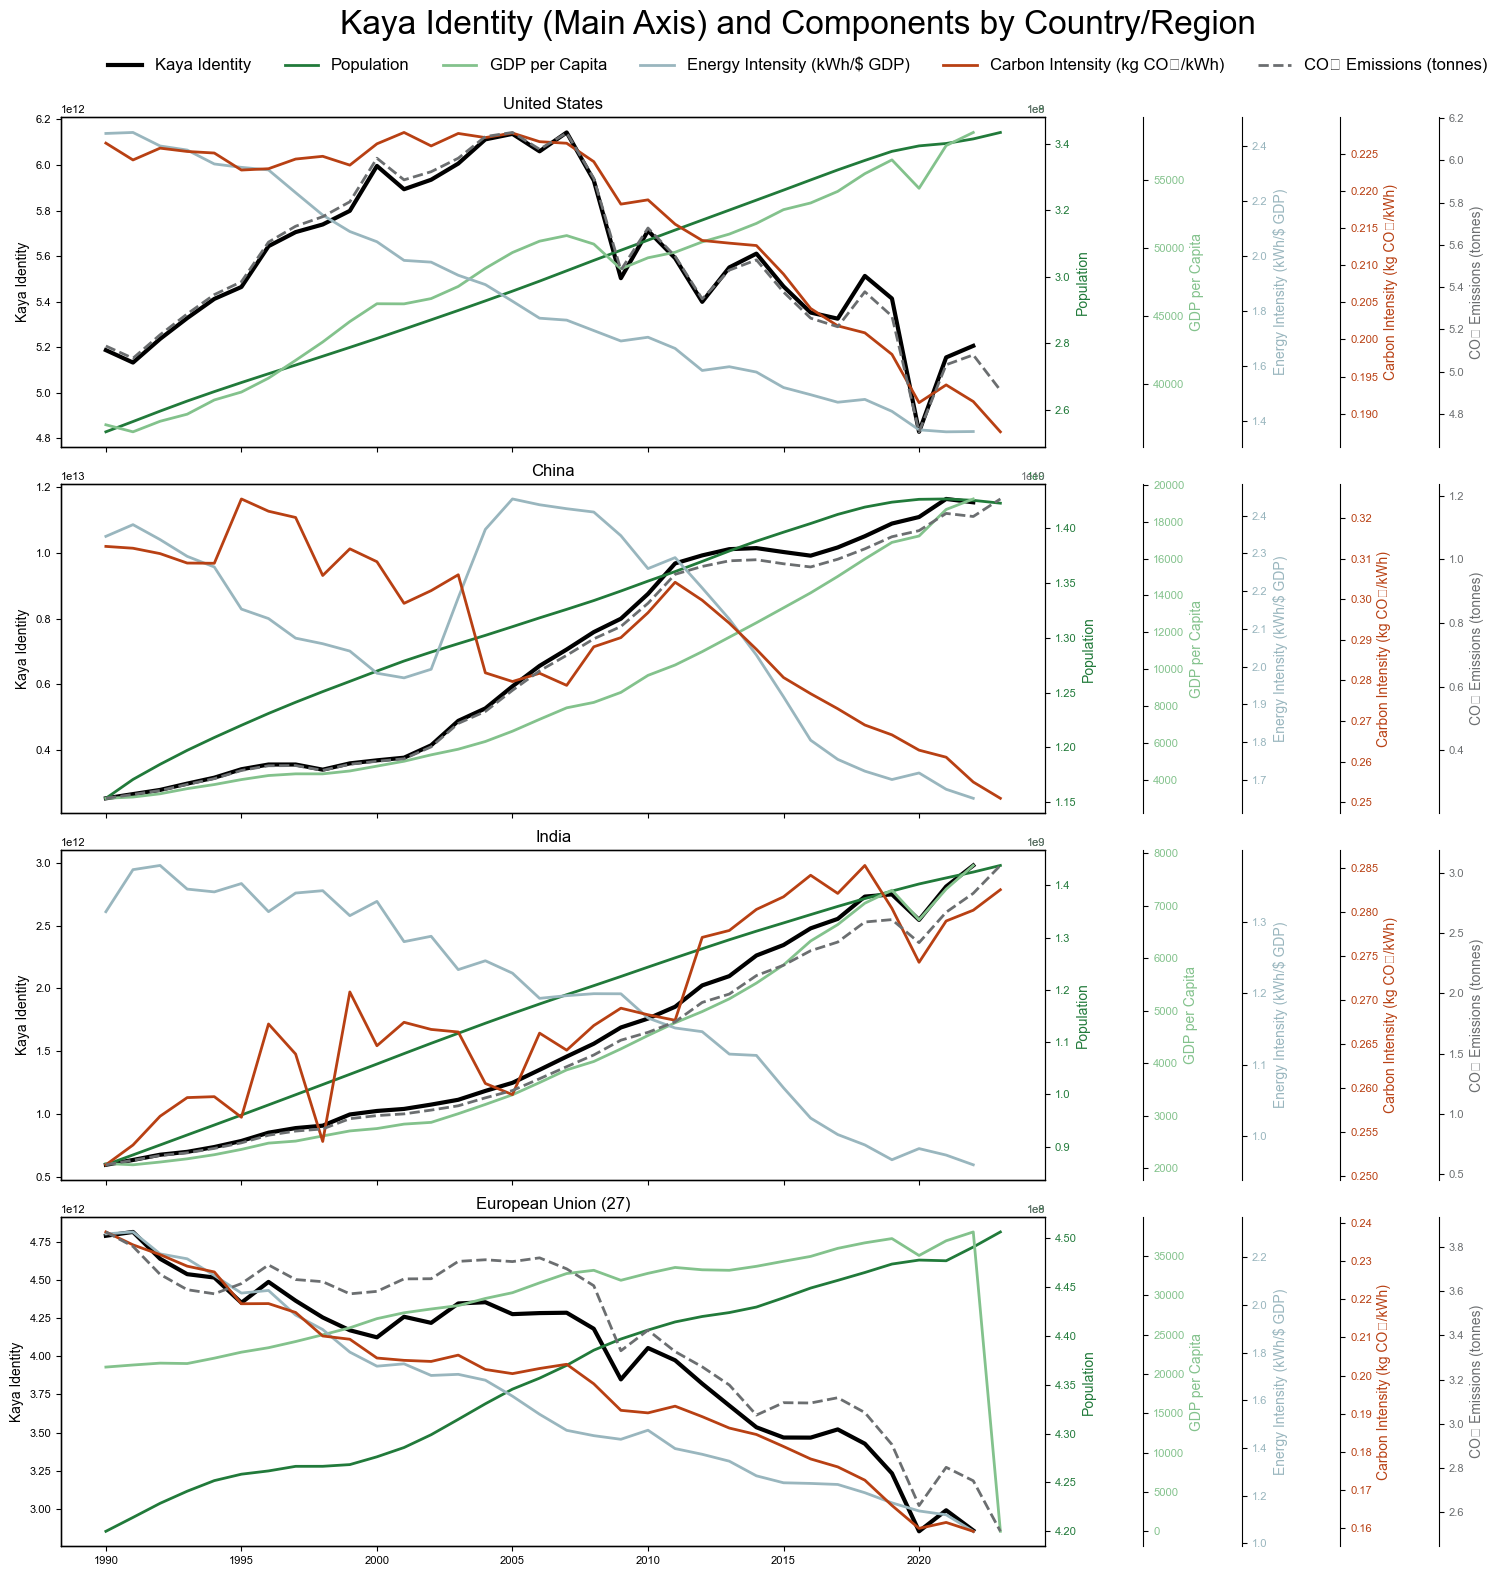

In [59]:


def plot_kaya_identity_main_axis(df, entities, year_start=1990, year_end=2023):
    components = [
        ('Population (historical)', 'Population'),
        ('GDP per capita', 'GDP per Capita'),
        ('Primary energy consumption per GDP (kWh/$)', 'Energy Intensity (kWh/$ GDP)'),
        ('Annual CO₂ emissions per unit energy (kg per kilowatt-hour)', 'Carbon Intensity (kg CO₂/kWh)')
    ]
    colors = [green, lightgreen, '#99b6be', burntorange]
    emission_col = ('Annual CO₂ emissions', 'CO₂ Emissions (tonnes)')

    n = len(entities)
    fig, axs = plt.subplots(n, 1, figsize=(16, 4 * n), sharex=True)

    if n == 1:
        axs = [axs]

    for idx, entity in enumerate(entities):
        subset = df[(df['Entity'] == entity) & (df['Year'] >= year_start) & (df['Year'] <= year_end)].copy()
        if subset.empty:
            print(f"No data for {entity} between {year_start} and {year_end}")
            continue

        # --- Plot Kaya Identity (only where all components are valid and non-negative) ---
        valid_kaya = subset.copy()
        for col, _ in components:
            valid_kaya = valid_kaya[(valid_kaya[col] >= 0) & (~valid_kaya[col].isna())]
        valid_kaya['Kaya Identity'] = (
            valid_kaya[components[0][0]] *
            valid_kaya[components[1][0]] *
            valid_kaya[components[2][0]] *
            valid_kaya[components[3][0]]
        )

        ax = axs[idx]
        ax.set_title(entity)
        lines = []
        # Kaya Identity as thick black line
        l_kaya, = ax.plot(valid_kaya['Year'], valid_kaya['Kaya Identity'], color='black', linewidth=3, label='Kaya Identity')
        lines.append(l_kaya)
        ax.set_ylabel('Kaya Identity', color='black')
        # ax.set_xlabel('Year', color='black')
        ax.tick_params(axis='y', labelcolor='black')
        # ax.tick_params(axis='x', labelcolor='black')

        y_axes = [ax]

        # --- Plot each component on its own y-axis, only where valid ---
        for i, (col, label) in enumerate(components):
            ax_new = ax.twinx()
            ax_new.spines["right"].set_position(("axes", 1 + 0.1 * i))
            valid_comp = subset[(subset[col] >= 0) & (~subset[col].isna())]
            l, = ax_new.plot(valid_comp['Year'], valid_comp[col], color=colors[i], label=label, linewidth=2)
            lines.append(l)
            ax_new.set_ylabel(label, color=colors[i])
            ax_new.tick_params(axis='y', labelcolor=colors[i])
            y_axes.append(ax_new)
            

        # --- Plot actual CO₂ emissions on the last y-axis, only where valid ---
        ax_em = ax.twinx()
        ax_em.spines["right"].set_position(("axes", 1 + 0.1 * len(components)))
        valid_em = subset[(subset[emission_col[0]] >= 0) & (~subset[emission_col[0]].isna())]
        l_em, = ax_em.plot(valid_em['Year'], valid_em[emission_col[0]], color=gray, label=emission_col[1], linewidth=2, linestyle='dashed')
        lines.append(l_em)
        ax_em.set_ylabel(emission_col[1], color=gray)
        ax_em.tick_params(axis='y', labelcolor=gray)
        y_axes.append(ax_em)
        # ax_em.set_xlabel("Year")
        # ax_em.tick_params(axis='x', labelcolor=gray)

        if idx == 0:
            labels = ['Kaya Identity'] + [comp[1] for comp in components] + [emission_col[1]]
            fig.legend(
                lines, labels,
                loc='upper center',
                bbox_to_anchor=(0.5, 0.96),
                ncol=len(labels),
                fontsize=12,
                frameon=False
            )
        
    plt.xlabel("Year")
    # plt.grid(True)
    plt.suptitle("Kaya Identity (Main Axis) and Components by Country/Region", fontsize=24, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage:
# entities = [
#     "China", "United States", "European Union (27)", "India",
#     "Middle East", "Africa", "Central and South America"
# ]

entities = ['United States', 'China', 'India', 'European Union (27)']
plot_kaya_identity_main_axis(df_final, entities, 1990, 2023)



/var/folders/gf/lf9k9p2j5j5fcvdnh2mcnqpc0000gn/T/ipykernel_55196/2317248785.py:33: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/amyliu/Documents/OpenMinds/OM/om-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


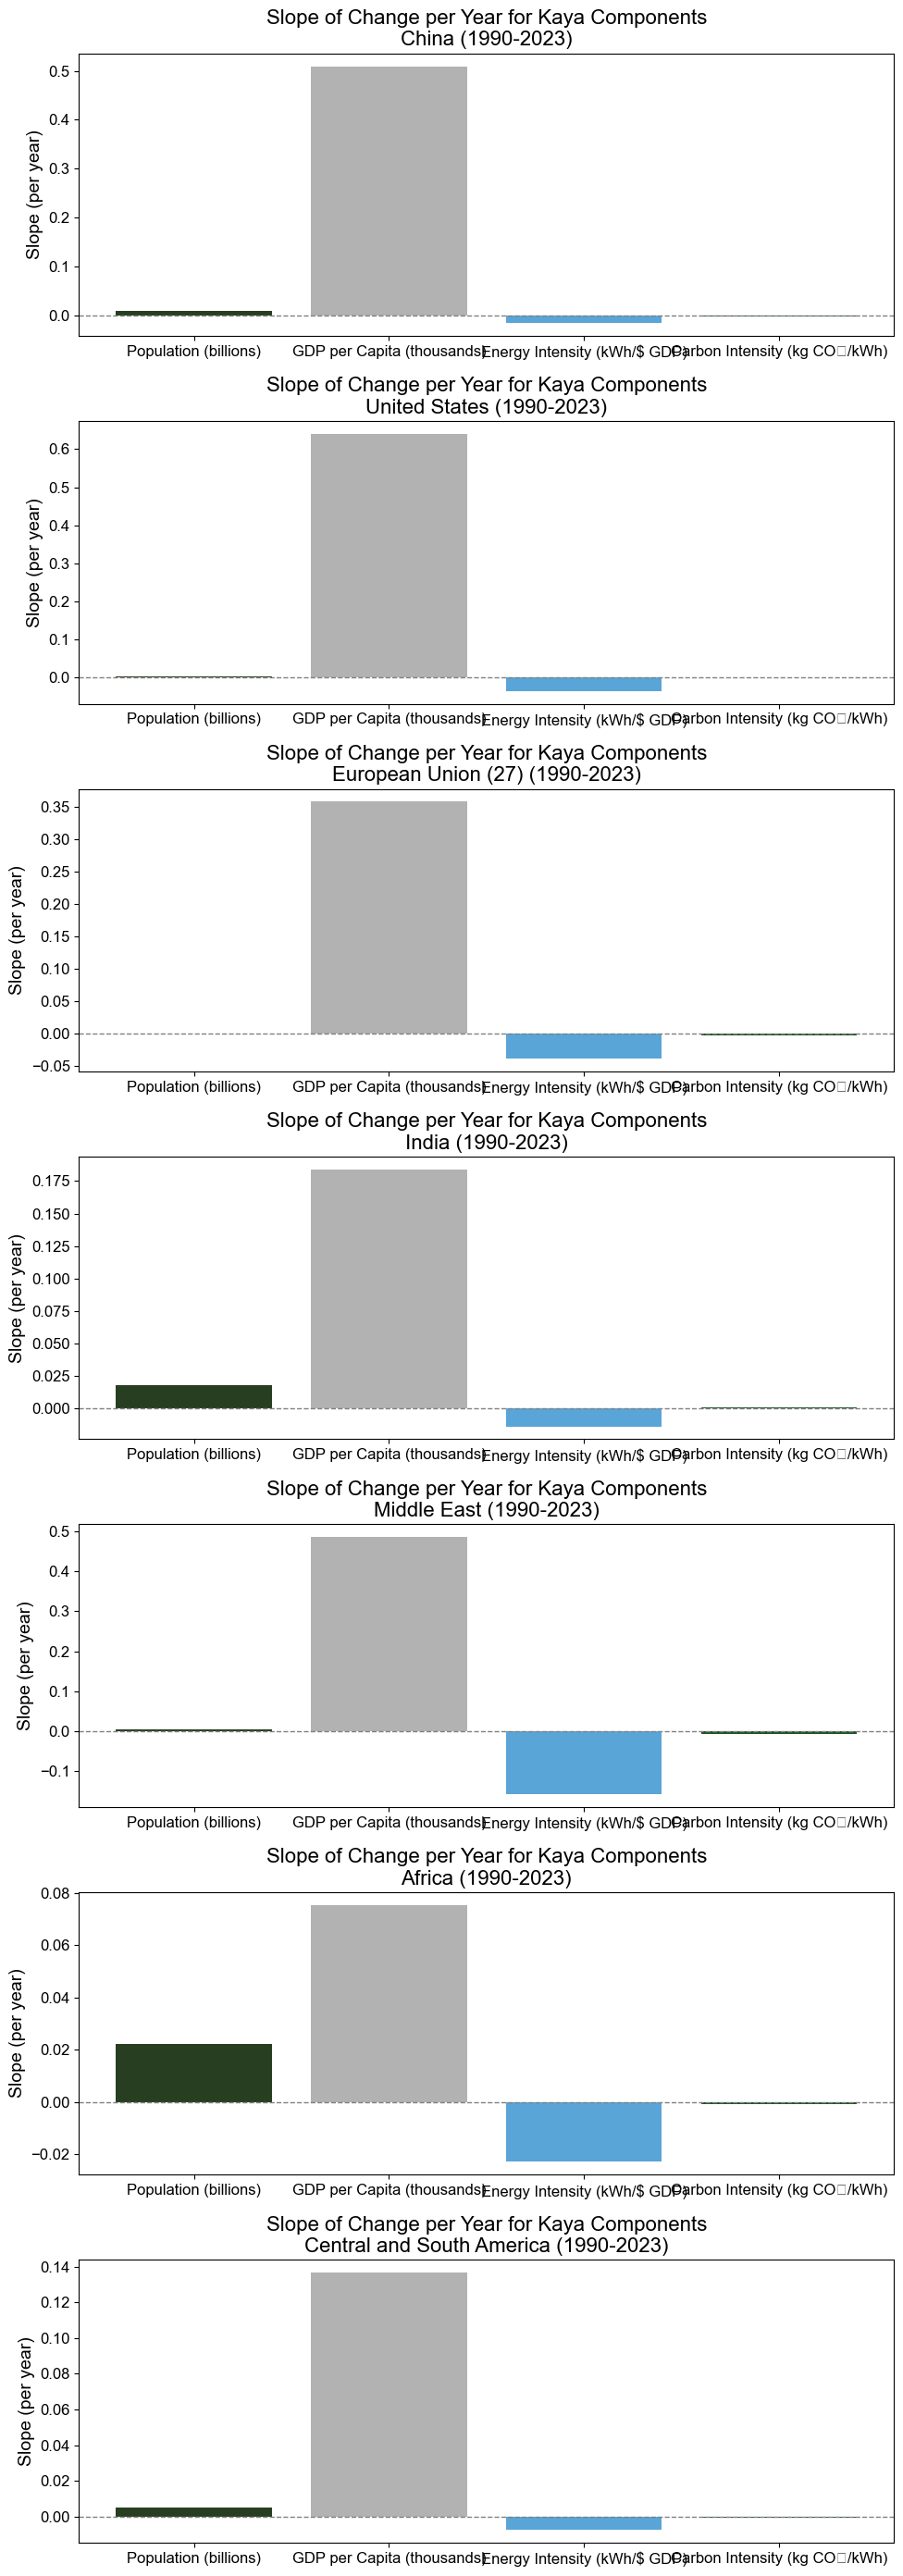

In [ ]:
def kaya_slopes_bar_all_scaled(df, entities, year_start=1990, year_end=2023):
    components = [
        ('Population (historical)', 'Population (billions)', 1e9),
        ('GDP per capita', 'GDP per Capita (thousands)', 1e3),
        ('Primary energy consumption per GDP (kWh/$)', 'Energy Intensity (kWh/$ GDP)', 1),
        ('Annual CO₂ emissions per unit energy (kg per kilowatt-hour)', 'Carbon Intensity (kg CO₂/kWh)', 1)
    ]
    colors = [darkgreen, lightgray, '#99b6be', forestgreen]

    n = len(entities)
    fig, axs = plt.subplots(n, 1, figsize=(10, 4 * n), sharex=False)

    if n == 1:
        axs = [axs]

    for idx, entity in enumerate(entities):
        subset = df[(df['Entity'] == entity) & (df['Year'] >= year_start) & (df['Year'] <= year_end)]
        slopes = []
        for col, label, scale in components:
            valid = subset[['Year', col]].dropna()
            valid = valid[valid[col] >= 0]
            if len(valid) < 2:
                slope = np.nan
            else:
                years = valid['Year'].values
                y = valid[col].values / scale
                slope, _ = np.polyfit(years, y, 1)
            slopes.append(slope)
        axs[idx].bar([label for _, label, _ in components], slopes, color=colors)
        axs[idx].set_title(f"Slope of Change per Year for Kaya Components\n{entity} ({year_start}-{year_end})")
        axs[idx].set_ylabel("Slope (per year)")
        axs[idx].axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# Example usage:
entities = [
    "China", "United States", "European Union (27)", "India",
    "Middle East", "Africa", "Central and South America"
]
kaya_slopes_bar_all_scaled(df_final, entities, 1990, 2023)




In [52]:
axs

NameError: name 'axs' is not defined

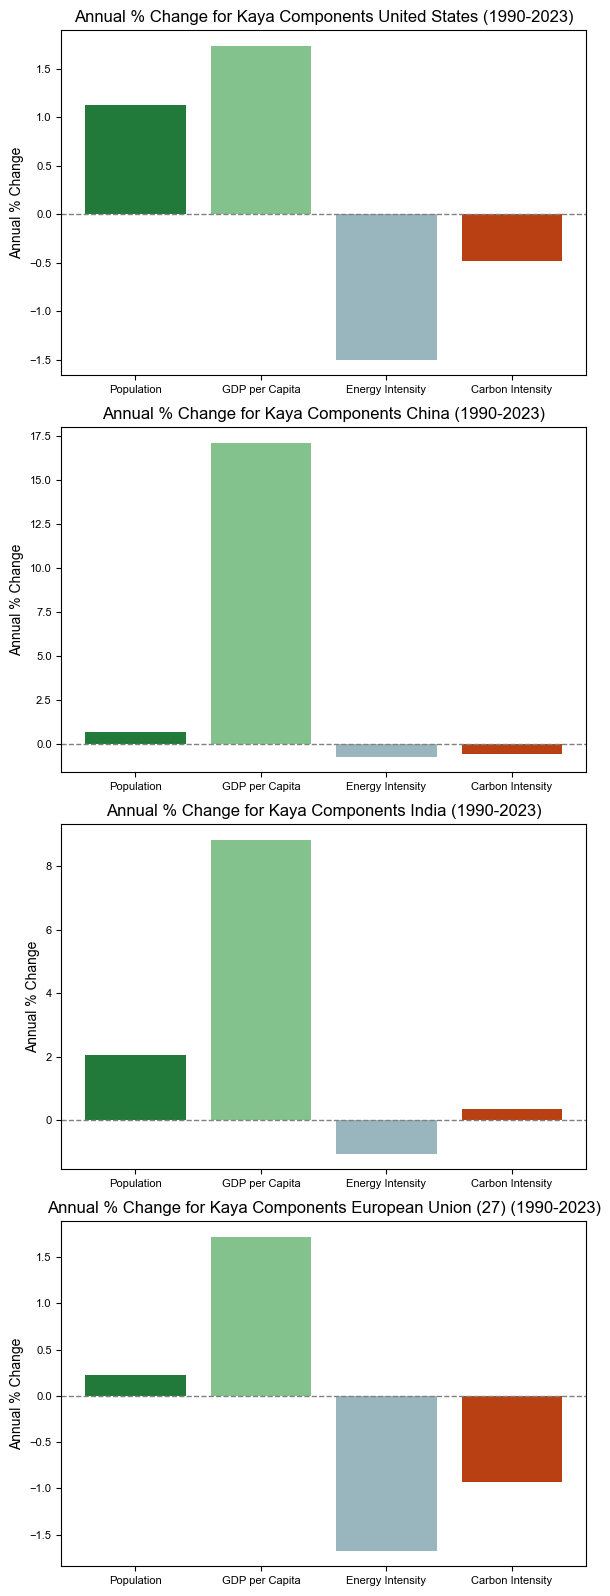

In [58]:
def kaya_slopes_bar_all_percent(df, entities, year_start=1990, year_end=2023):
    components = [
        ('Population (historical)', 'Population'),
        ('GDP per capita', 'GDP per Capita'),
        ('Primary energy consumption per GDP (kWh/$)', 'Energy Intensity'),
        ('Annual CO₂ emissions per unit energy (kg per kilowatt-hour)', 'Carbon Intensity')
    ]
    colors = [green, lightgreen, '#99b6be', burntorange]

    n = len(entities)
    fig, axs = plt.subplots(n, 1, figsize=(6, 4 * n), sharex=False)
    # fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

    if n == 1:
        axs = [axs]

    for idx, entity in enumerate(entities):
        subset = df[(df['Entity'] == entity) & (df['Year'] >= year_start) & (df['Year'] <= year_end)]
        percent_slopes = []
        for col, label in components:
            valid = subset[['Year', col]].dropna()
            valid = valid[valid[col] >= 0]
            if len(valid) < 2:
                percent_slope = np.nan
            else:
                years = valid['Year'].values
                y = valid[col].values
                slope, _ = np.polyfit(years, y, 1)
                initial = y[0]
                percent_slope = (slope / initial) * 100 if initial != 0 else np.nan
            percent_slopes.append(percent_slope)
        axs[idx].bar([label for _, label in components], percent_slopes, color=colors)
        axs[idx].set_title(f"Annual % Change for Kaya Components {entity} ({year_start}-{year_end})")
        axs[idx].set_ylabel("Annual % Change")
        axs[idx].axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# Example usage:
# entities = [
#     "China", "United States", "European Union (27)", "India",
#     "Middle East", "Africa", "Central and South America"
# ]

entities = ['United States', 'China', 'India', 'European Union (27)']
kaya_slopes_bar_all_percent(df_final, entities, 1990, 2023)


/Users/amyliu/Documents/OpenMinds/OM/om-env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amyliu/Documents/OpenMinds/OM/om-env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amyliu/Documents/OpenMinds/OM/om-env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amyliu/Documents/OpenMinds/OM/om-env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


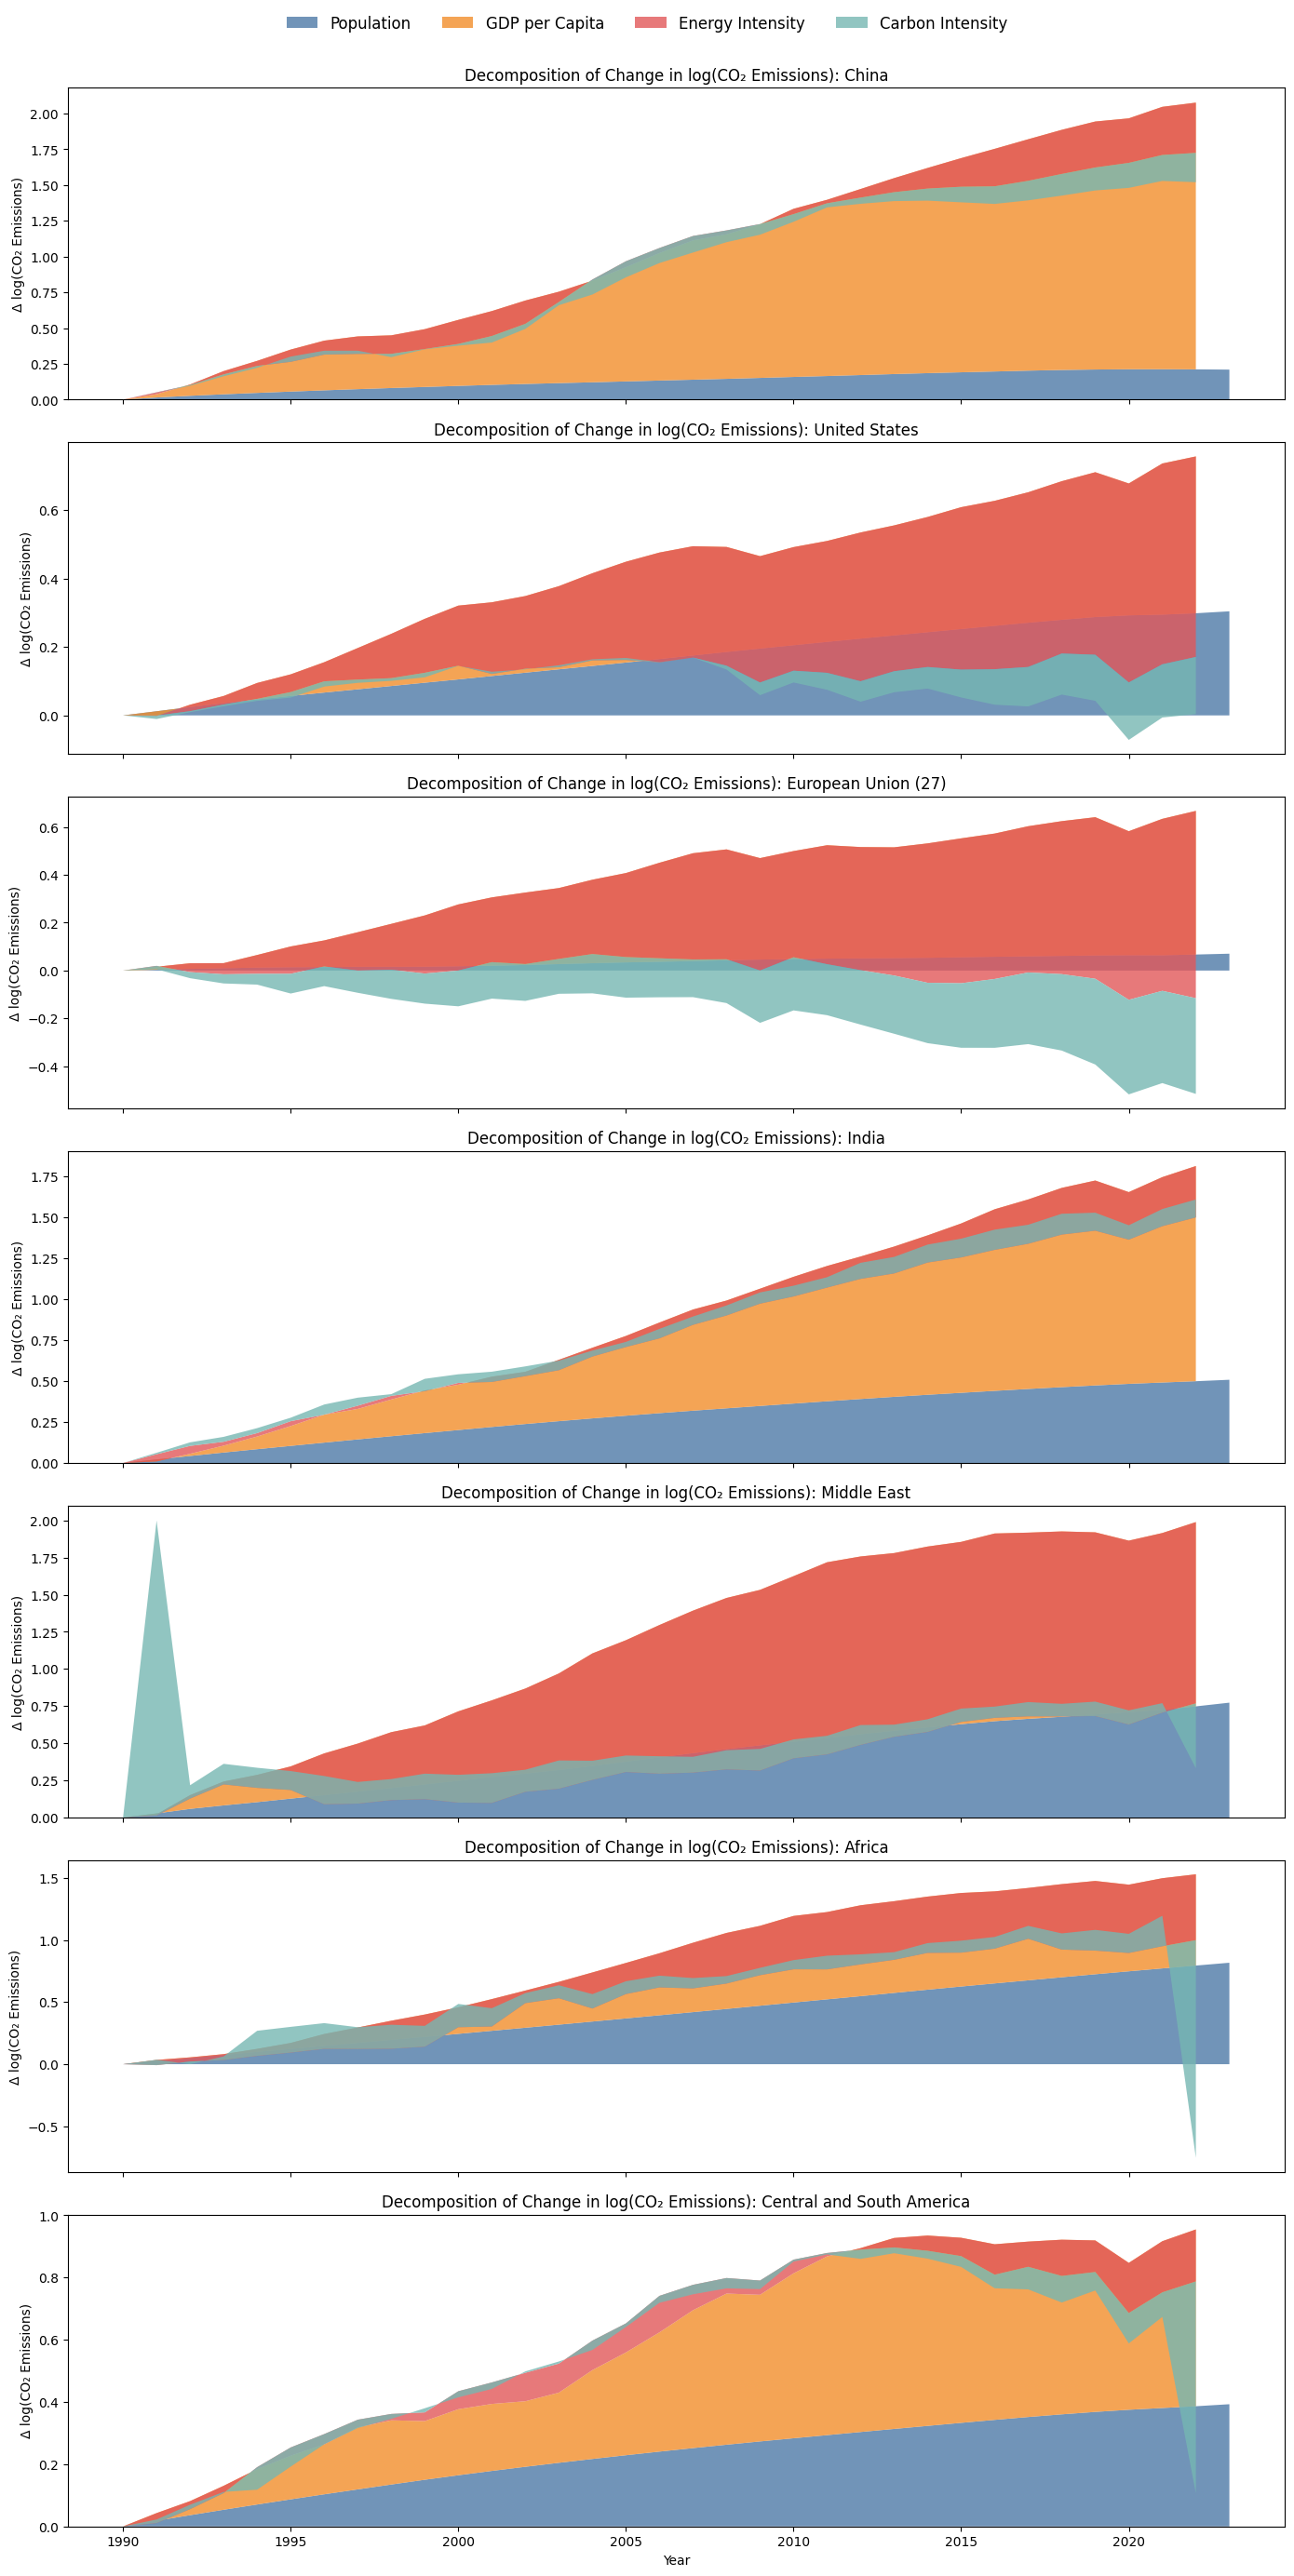

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def kaya_decomposition_stacked_all(df, entities, year_start=1990, year_end=2023):
    labels = ['Population', 'GDP per Capita', 'Energy Intensity', 'Carbon Intensity']
    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']
    n = len(entities)
    fig, axs = plt.subplots(n, 1, figsize=(14, 4 * n), sharex=True)

    if n == 1:
        axs = [axs]

    for idx, entity in enumerate(entities):
        subset = df[(df['Entity'] == entity) & (df['Year'] >= year_start) & (df['Year'] <= year_end)].copy()
        if subset.empty:
            print(f"No data for {entity} between {year_start} and {year_end}")
            continue

        def safe_log(series):
            return np.log(series.where((series >= 0) & (~series.isna())))

        log_pop = safe_log(subset['Population (historical)'])
        log_gdp_pc = safe_log(subset['GDP per capita'])
        log_ei = safe_log(subset['Primary energy consumption per GDP (kWh/$)'])
        log_ci = safe_log(subset['Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'])

        dlog_pop = log_pop - log_pop.iloc[0]
        dlog_gdp_pc = log_gdp_pc - log_gdp_pc.iloc[0]
        dlog_ei = log_ei - log_ei.iloc[0]
        dlog_ci = log_ci - log_ci.iloc[0]

        years = subset['Year'].values
        contributions = np.vstack([dlog_pop, dlog_gdp_pc, dlog_ei, dlog_ci])

        axs[idx].stackplot(years, contributions, colors=colors, alpha=0.8)
        axs[idx].set_title(f"Decomposition of Change in log(CO₂ Emissions): {entity}")
        axs[idx].set_ylabel("Δ log(CO₂ Emissions)")

    axs[-1].set_xlabel("Year")
    # Add a single shared legend for the colors/components
    fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4, fontsize=12, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Example usage:
entities = [
    "China", "United States", "European Union (27)", "India",
    "Middle East", "Africa", "Central and South America"
]
kaya_decomposition_stacked_all(df_final, entities, 1990, 2023)


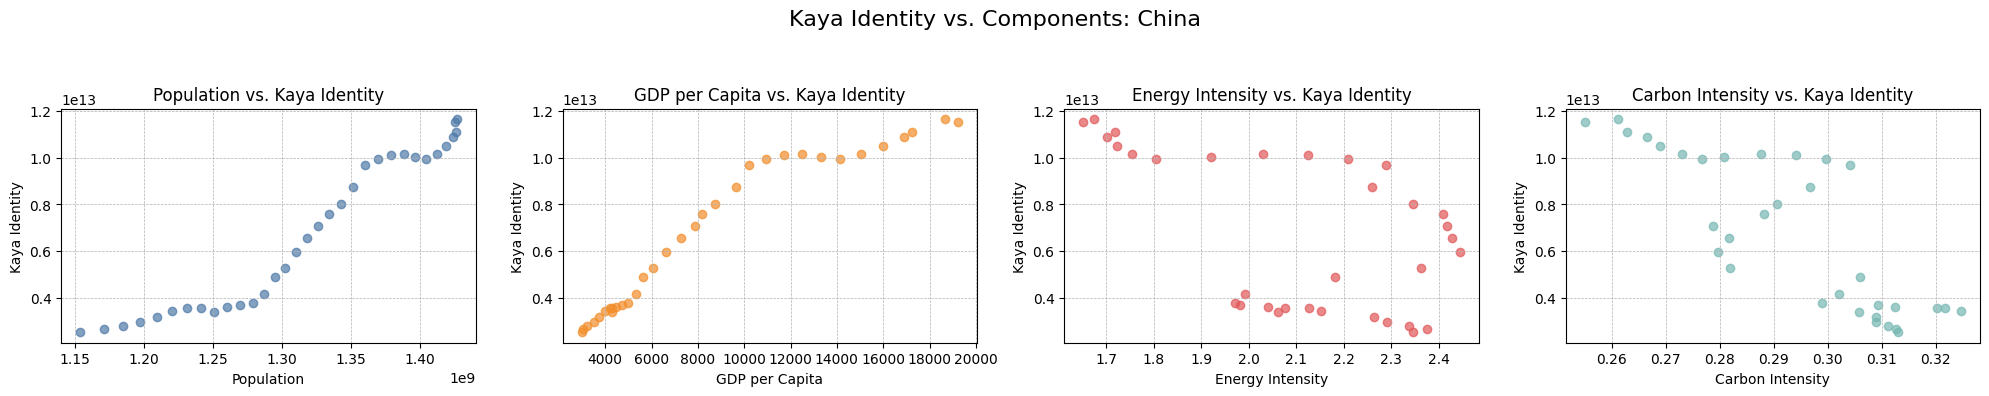

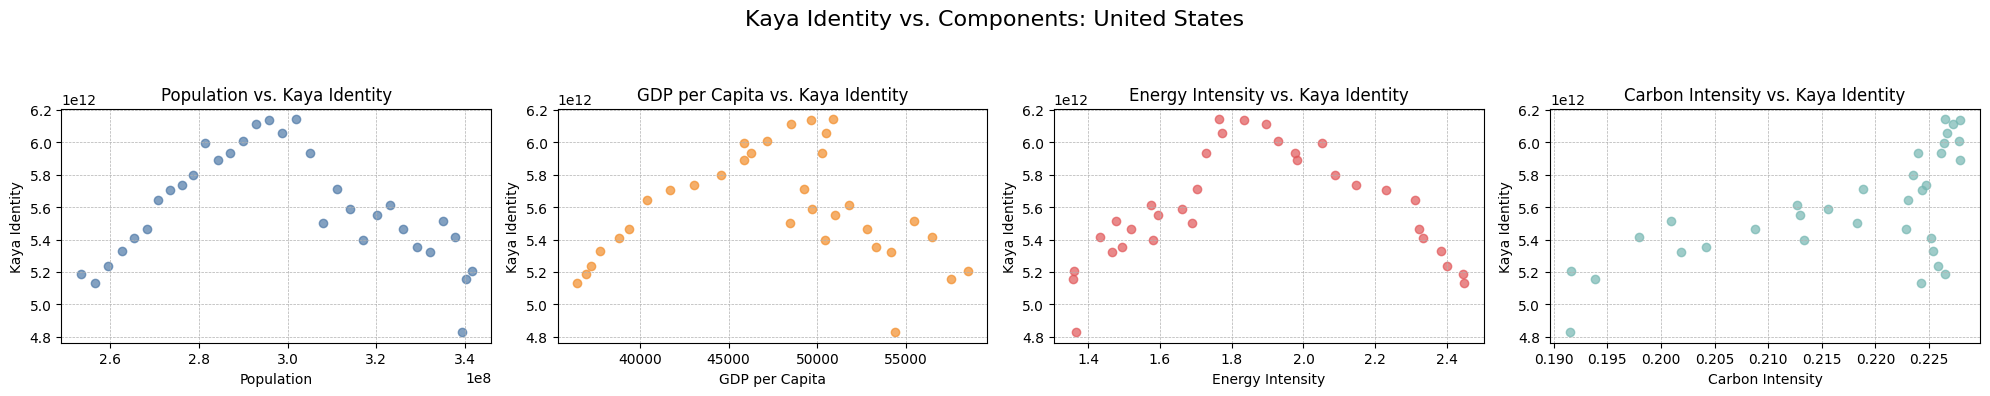

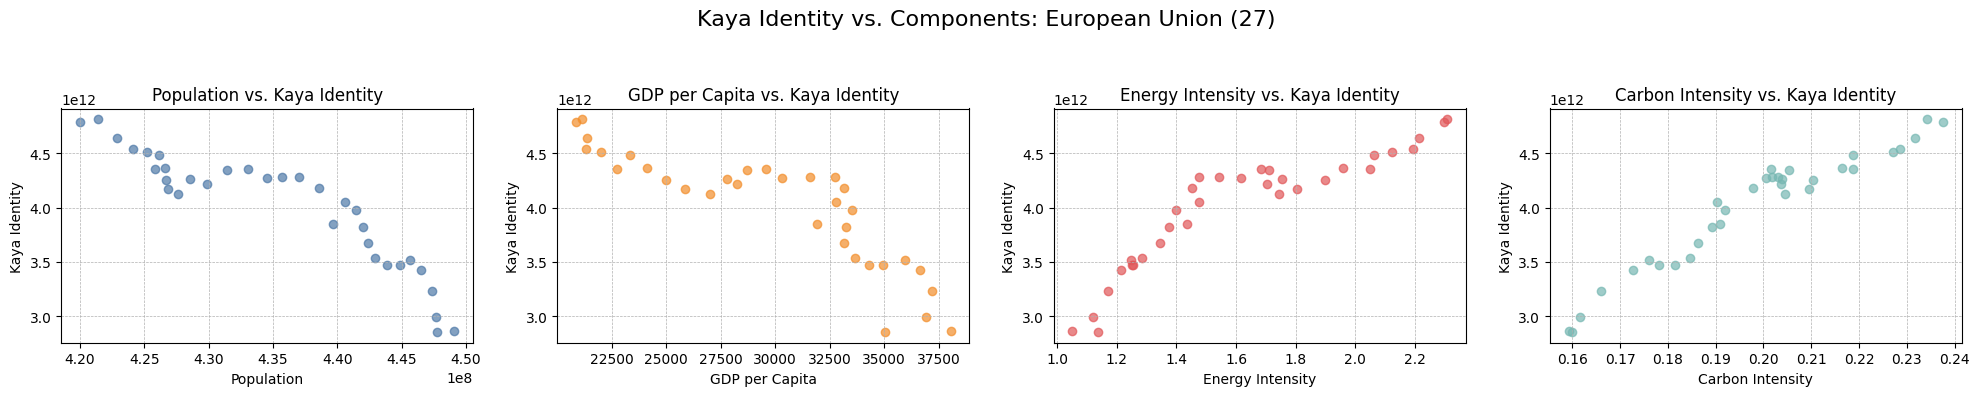

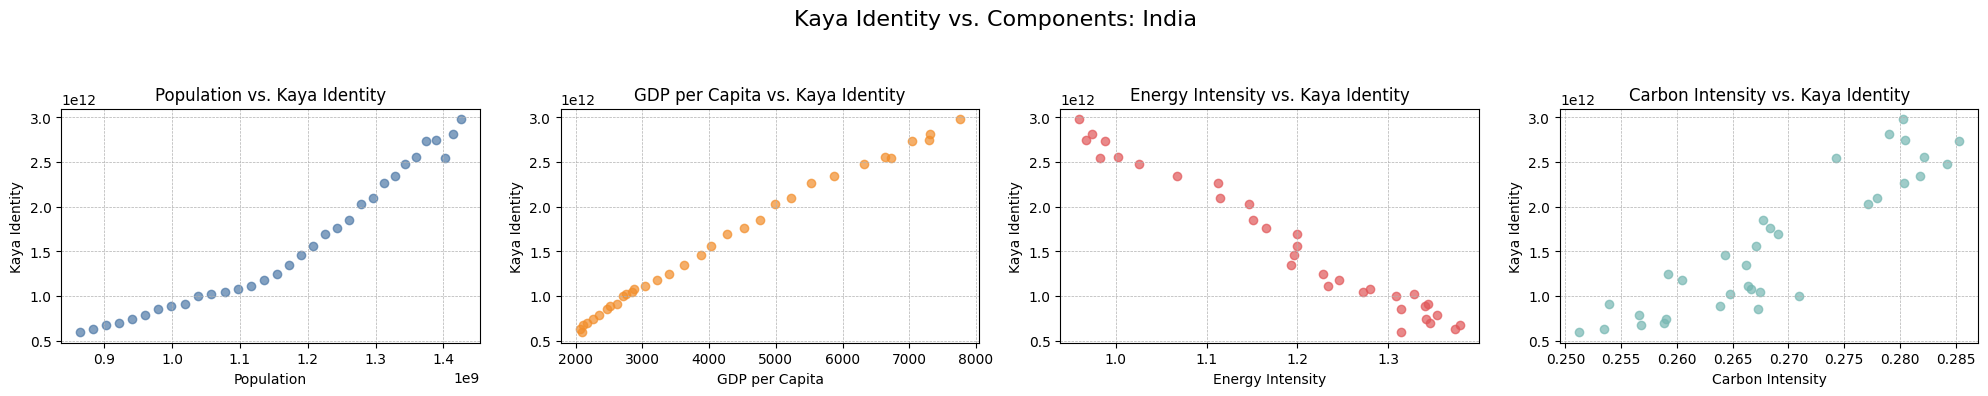

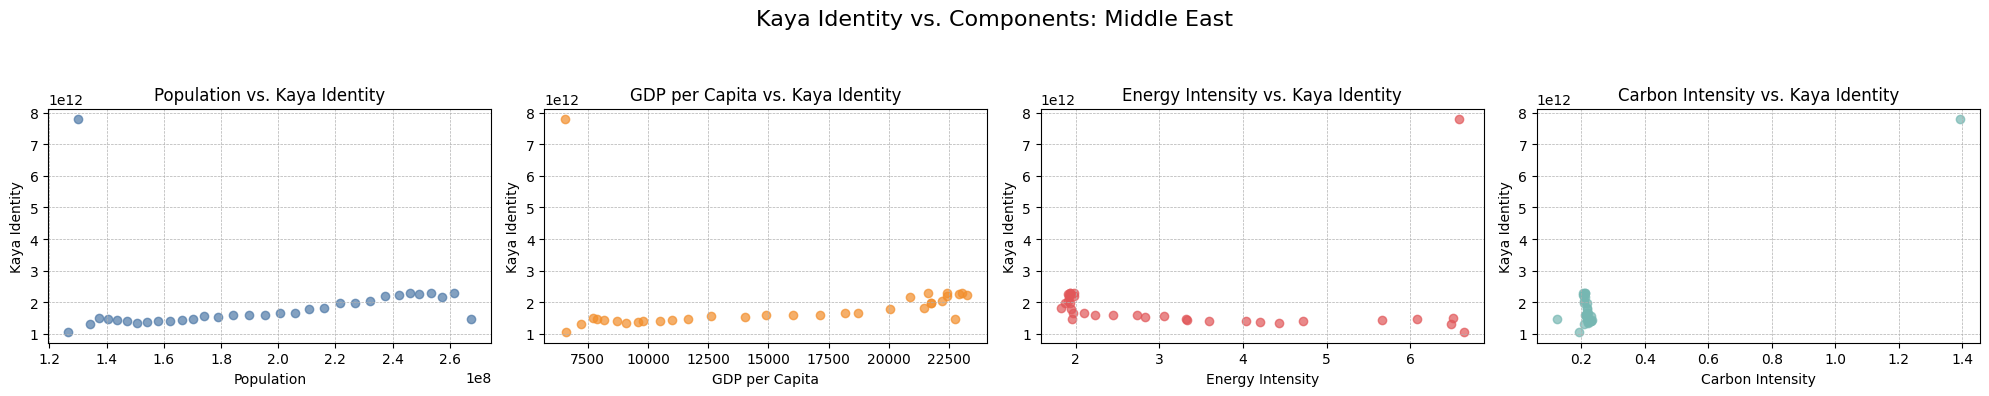

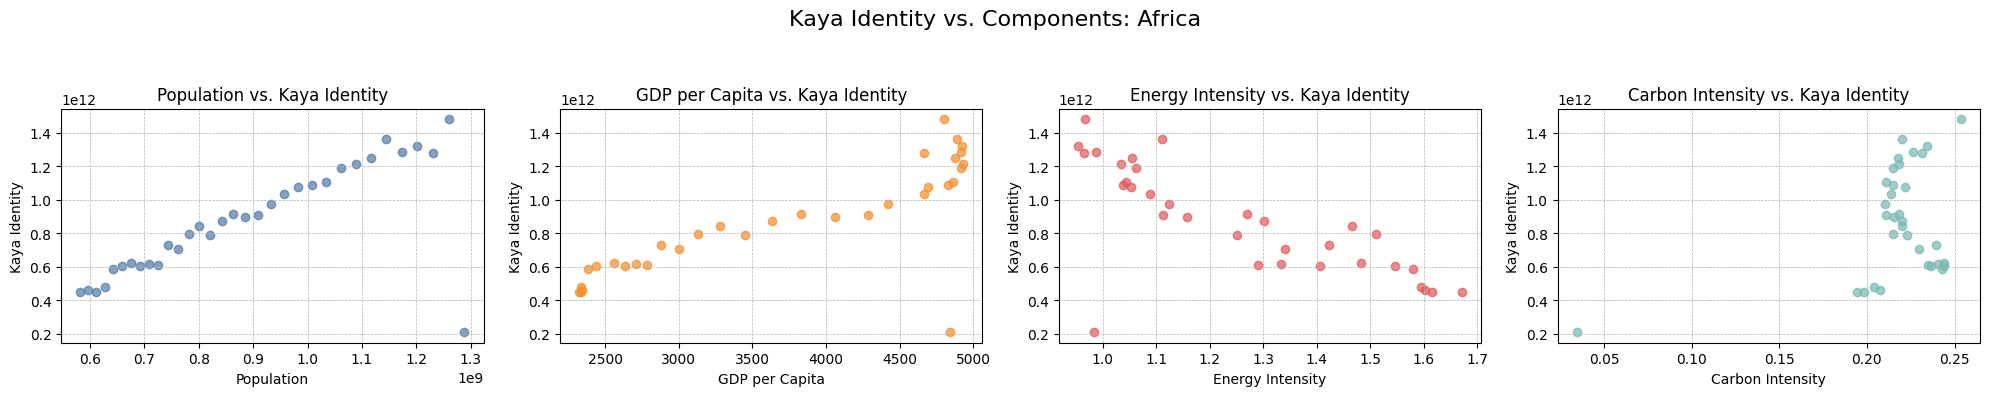

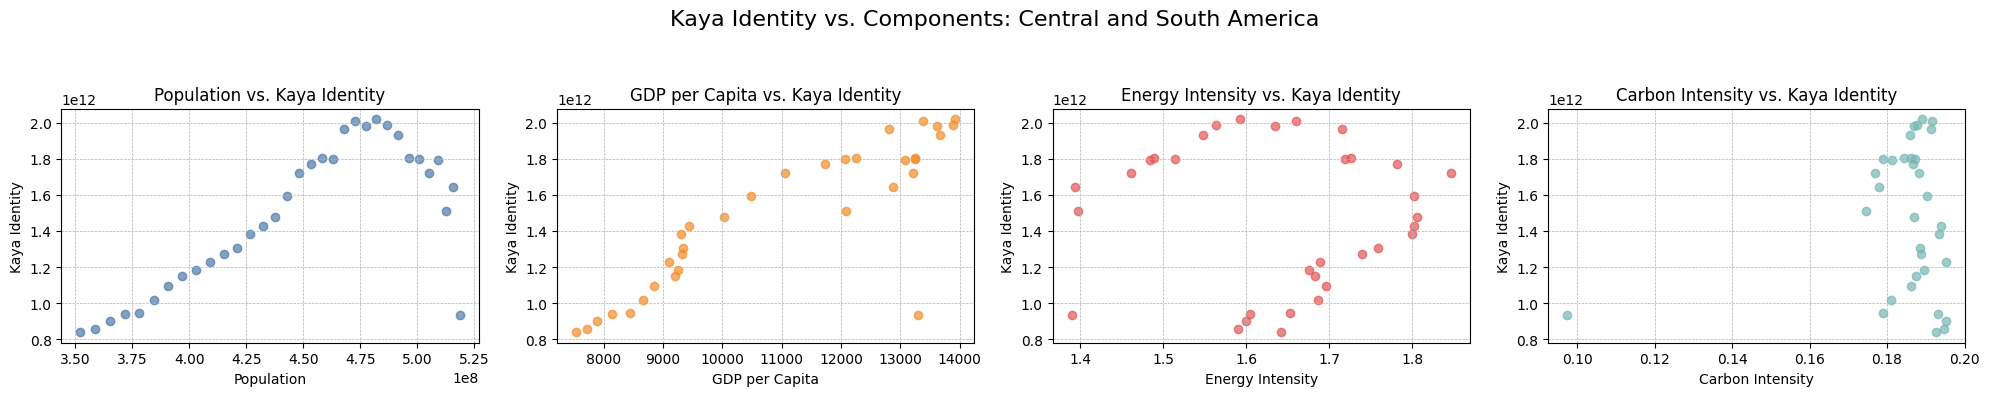

In [100]:
def kaya_correlation_subplots(df, entity, year_start=1990, year_end=2023):
    components = [
        ('Population (historical)', 'Population'),
        ('GDP per capita', 'GDP per Capita'),
        ('Primary energy consumption per GDP (kWh/$)', 'Energy Intensity'),
        ('Annual CO₂ emissions per unit energy (kg per kilowatt-hour)', 'Carbon Intensity')
    ]
    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']

    subset = df[(df['Entity'] == entity) & (df['Year'] >= year_start) & (df['Year'] <= year_end)].copy()
    if subset.empty:
        print(f"No data for {entity} between {year_start} and {year_end}")
        return

    # Calculate Kaya Identity only where all components are valid
    valid_kaya = subset.copy()
    for col, _ in components:
        valid_kaya = valid_kaya[(valid_kaya[col] >= 0) & (~valid_kaya[col].isna())]
    valid_kaya['Kaya Identity'] = (
        valid_kaya[components[0][0]] *
        valid_kaya[components[1][0]] *
        valid_kaya[components[2][0]] *
        valid_kaya[components[3][0]]
    )

    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    for i, (col, label) in enumerate(components):
        # Only plot where both the component and Kaya Identity are valid
        valid = valid_kaya[(valid_kaya[col] >= 0) & (~valid_kaya[col].isna()) & (valid_kaya['Kaya Identity'] >= 0) & (~valid_kaya['Kaya Identity'].isna())]
        axs[i].scatter(valid[col], valid['Kaya Identity'], color=colors[i], alpha=0.7)
        axs[i].set_xlabel(label)
        axs[i].set_ylabel("Kaya Identity")
        axs[i].set_title(f"{label} vs. Kaya Identity")
        axs[i].grid(True, linestyle='--', linewidth=0.5)
    fig.suptitle(f"Kaya Identity vs. Components: {entity}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage for all regions:
entities = [
    "China", "United States", "European Union (27)", "India",
    "Middle East", "Africa", "Central and South America"
]
for entity in entities:
    kaya_correlation_subplots(df_final, entity, 1990, 2023)




# Kaya Identity Components - Bar Charts
# 
# This notebook creates bar charts showing how each component of the Kaya identity has changed from 1990-2023 for a selected region.
# 
# The Kaya identity breaks down CO₂ emissions into four components:
# 1. **Population** - Number of people
# 2. **GDP per capita** - Economic output per person
# 3. **Energy intensity** - Energy consumption per unit of GDP
# 4. **Carbon intensity** - CO₂ emissions per unit of energy consumed
# 
# CO₂ emissions = Population × GDP per capita × Energy intensity × Carbon intensity



In [37]:
# Cell 2: Imports and Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, Dropdown
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Color scheme for the components
colors = {
    'CO₂ Emissions': gray,
    'Population': green,
    'GDP per capita': lightgreen, 
    'Energy intensity': '#99b6be',
    'Carbon intensity': burntorange
}


In [2]:
# Cell 3: Load and Explore Data
# Load the data
df = pd.read_csv('kaya-identity-co2_1/kaya-identity-co2.csv')

# Clean column names
df.columns = df.columns.str.strip()

# Filter for years 1990-2023
df_filtered = df[(df['Year'] >= 1990) & (df['Year'] <= 2023)].copy()

# Get available regions
available_regions = sorted(df_filtered['Entity'].unique())
print(f"Available regions: {len(available_regions)}")
print("\nSample regions:")
for region in available_regions[:20]:
    print(f"  - {region}")

Available regions: 300

Sample regions:
  - Afghanistan
  - Africa
  - Africa (GCP)
  - Africa (UN)
  - Akrotiri and Dhekelia
  - Albania
  - Algeria
  - American Samoa
  - Americas (UN)
  - Andorra
  - Angola
  - Anguilla
  - Antarctica
  - Antigua and Barbuda
  - Argentina
  - Armenia
  - Aruba
  - Asia
  - Asia (GCP)
  - Asia (UN)


In [42]:
compare_component_across_regions('Population', ['United States','European Union (27)','China','India'], year=2023)

NameError: name 'compare_component_across_regions' is not defined

In [43]:
# Cell 4: Main Function for Creating Bar Charts
def create_kaya_bar_charts(region_name):
    """
    Create bar charts for each Kaya identity component for a selected region.
    
    Parameters:
    region_name (str): Name of the region/country to analyze
    """
    
    # Filter data for the selected region
    region_data = df_filtered[df_filtered['Entity'] == region_name].copy()
    
    if len(region_data) == 0:
        print(f"No data available for {region_name}")
        return
    
    # Sort by year
    region_data = region_data.sort_values('Year')
    
    # Define the components and their corresponding columns
    components = {
        'Population': 'Population (historical)',
        'GDP per capita': 'GDP per capita',
        'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
        'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'
    }
    
    unit_labels = {
        'Population': 'Population (billions)',
        'GDP per capita': 'GDP per Capita ($)',
        'Energy intensity': 'Energy Intensity (kWh/$ GDP)',
        'Carbon intensity': 'Carbon Intensity (kg CO₂/kWh)'
    }

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(30, 16))
    fig.suptitle(f'Kaya Identity Components: {region_name} (1990-2023)', fontsize=30, fontweight='bold')
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    for idx, (component_name, column_name) in enumerate(components.items()):
        ax = axes[idx]
        
        # Get data for this component
        component_data = region_data[['Year', column_name]].dropna()
        
        if len(component_data) == 0:
            ax.text(0.5, 0.5, f'No data available\nfor {component_name}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=24)
            ax.set_title(f'{component_name}', fontweight='bold')
            continue
        
        # Create bar chart
        bars = ax.bar(component_data['Year'], component_data[column_name], 
                     color=colors[component_name], alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Customize the plot
        ax.set_title(f'{component_name}', fontweight='bold', fontsize=28)
        ax.set_xlabel('Year', fontsize=24)
        ax.set_ylabel(f'{unit_labels[component_name]}', fontsize=24)
        
        # Rotate x-axis labels for better readability
        # ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='x', labelsize=24)
        ax.tick_params(axis='y', labelsize=24)
        
        # Add grid
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars (every 5 years to avoid clutter)
        for i, (year, value) in enumerate(zip(component_data['Year'], component_data[column_name])):
            if i % 10 == 0 or i == len(component_data) - 1:  # Label every 5th bar and the last one
                ax.text(year, value, f'{value:.2f}', 
                       ha='center', va='bottom', fontsize=16)#, fontweight='bold')
        
        # Add trend line
        if len(component_data) > 1:
            z = np.polyfit(component_data['Year'], component_data[column_name], 1)
            p = np.poly1d(z)
            ax.plot(component_data['Year'], p(component_data['Year']), 
                   "r--", alpha=0.8, linewidth=2, label='Trend')
            # ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n�� Summary Statistics for {region_name}:")
    print("=" * 50)
    
    for component_name, column_name in components.items():
        component_data = region_data[column_name].dropna()
        if len(component_data) > 0:
            print(f"\n{component_name}:")
            print(f"  • Start (1990): {component_data.iloc[0]:.2f}")
            print(f"  • End (2023): {component_data.iloc[-1]:.2f}")
            print(f"  • Change: {((component_data.iloc[-1] - component_data.iloc[0]) / component_data.iloc[0] * 100):.1f}%")
            print(f"  • Average: {component_data.mean():.2f}")
            print(f"  • Std Dev: {component_data.std():.2f}")

In [91]:
# Cell 5: Interactive Widget
# Interactive widget for region selection
print("Select a region to view Kaya identity component bar charts:")

# Create dropdown widget
region_dropdown = Dropdown(
    options=available_regions,
    value='World',
    description='Region:',
    style={'description_width': 'initial'}
)

# Create interactive function
interact(create_kaya_bar_charts, region_name=region_dropdown)

Select a region to view Kaya identity component bar charts:


interactive(children=(Dropdown(description='Region:', index=293, options=('Afghanistan', 'Africa', 'Africa (GC…

<function __main__.create_kaya_bar_charts(region_name)>

Example: World


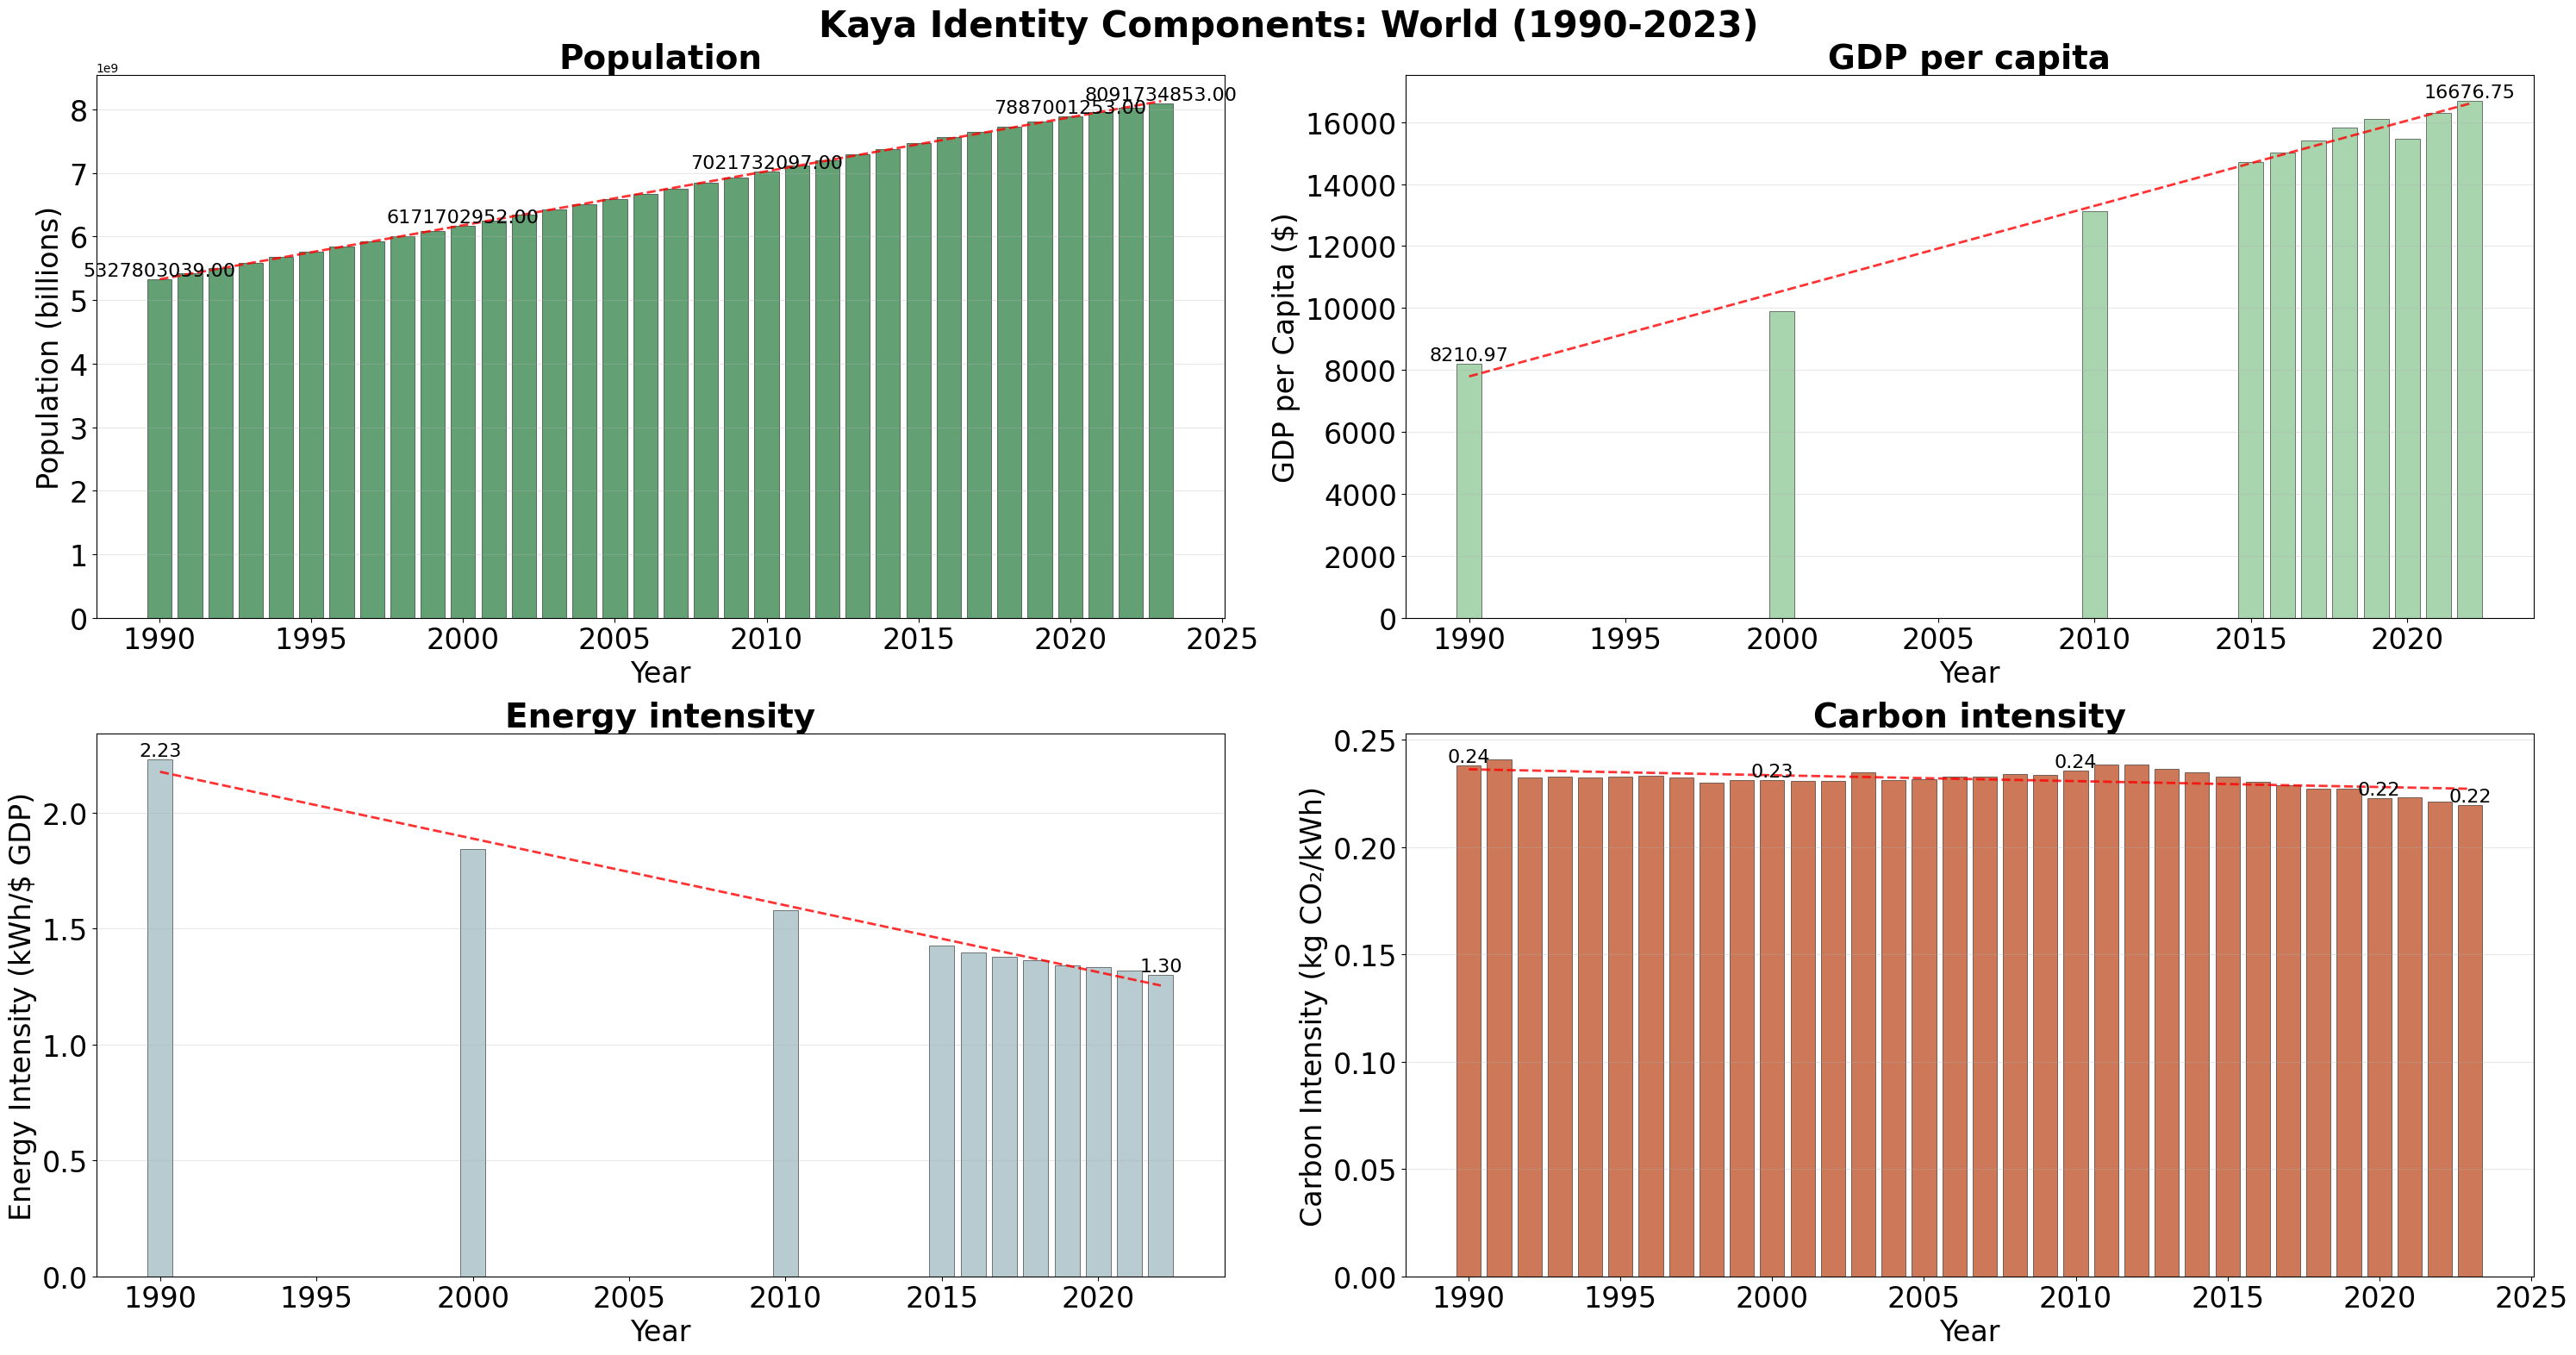


�� Summary Statistics for World:

Population:
  • Start (1990): 5327803039.00
  • End (2023): 8091734853.00
  • Change: 51.9%
  • Average: 6729417761.56
  • Std Dev: 845971875.52

GDP per capita:
  • Start (1990): 8210.97
  • End (2023): 16676.75
  • Change: 103.1%
  • Average: 14247.50
  • Std Dev: 2759.40

Energy intensity:
  • Start (1990): 2.23
  • End (2023): 1.30
  • Change: -41.7%
  • Average: 1.50
  • Std Dev: 0.29

Carbon intensity:
  • Start (1990): 0.24
  • End (2023): 0.22
  • Change: -7.7%
  • Average: 0.23
  • Std Dev: 0.00


Example: United States


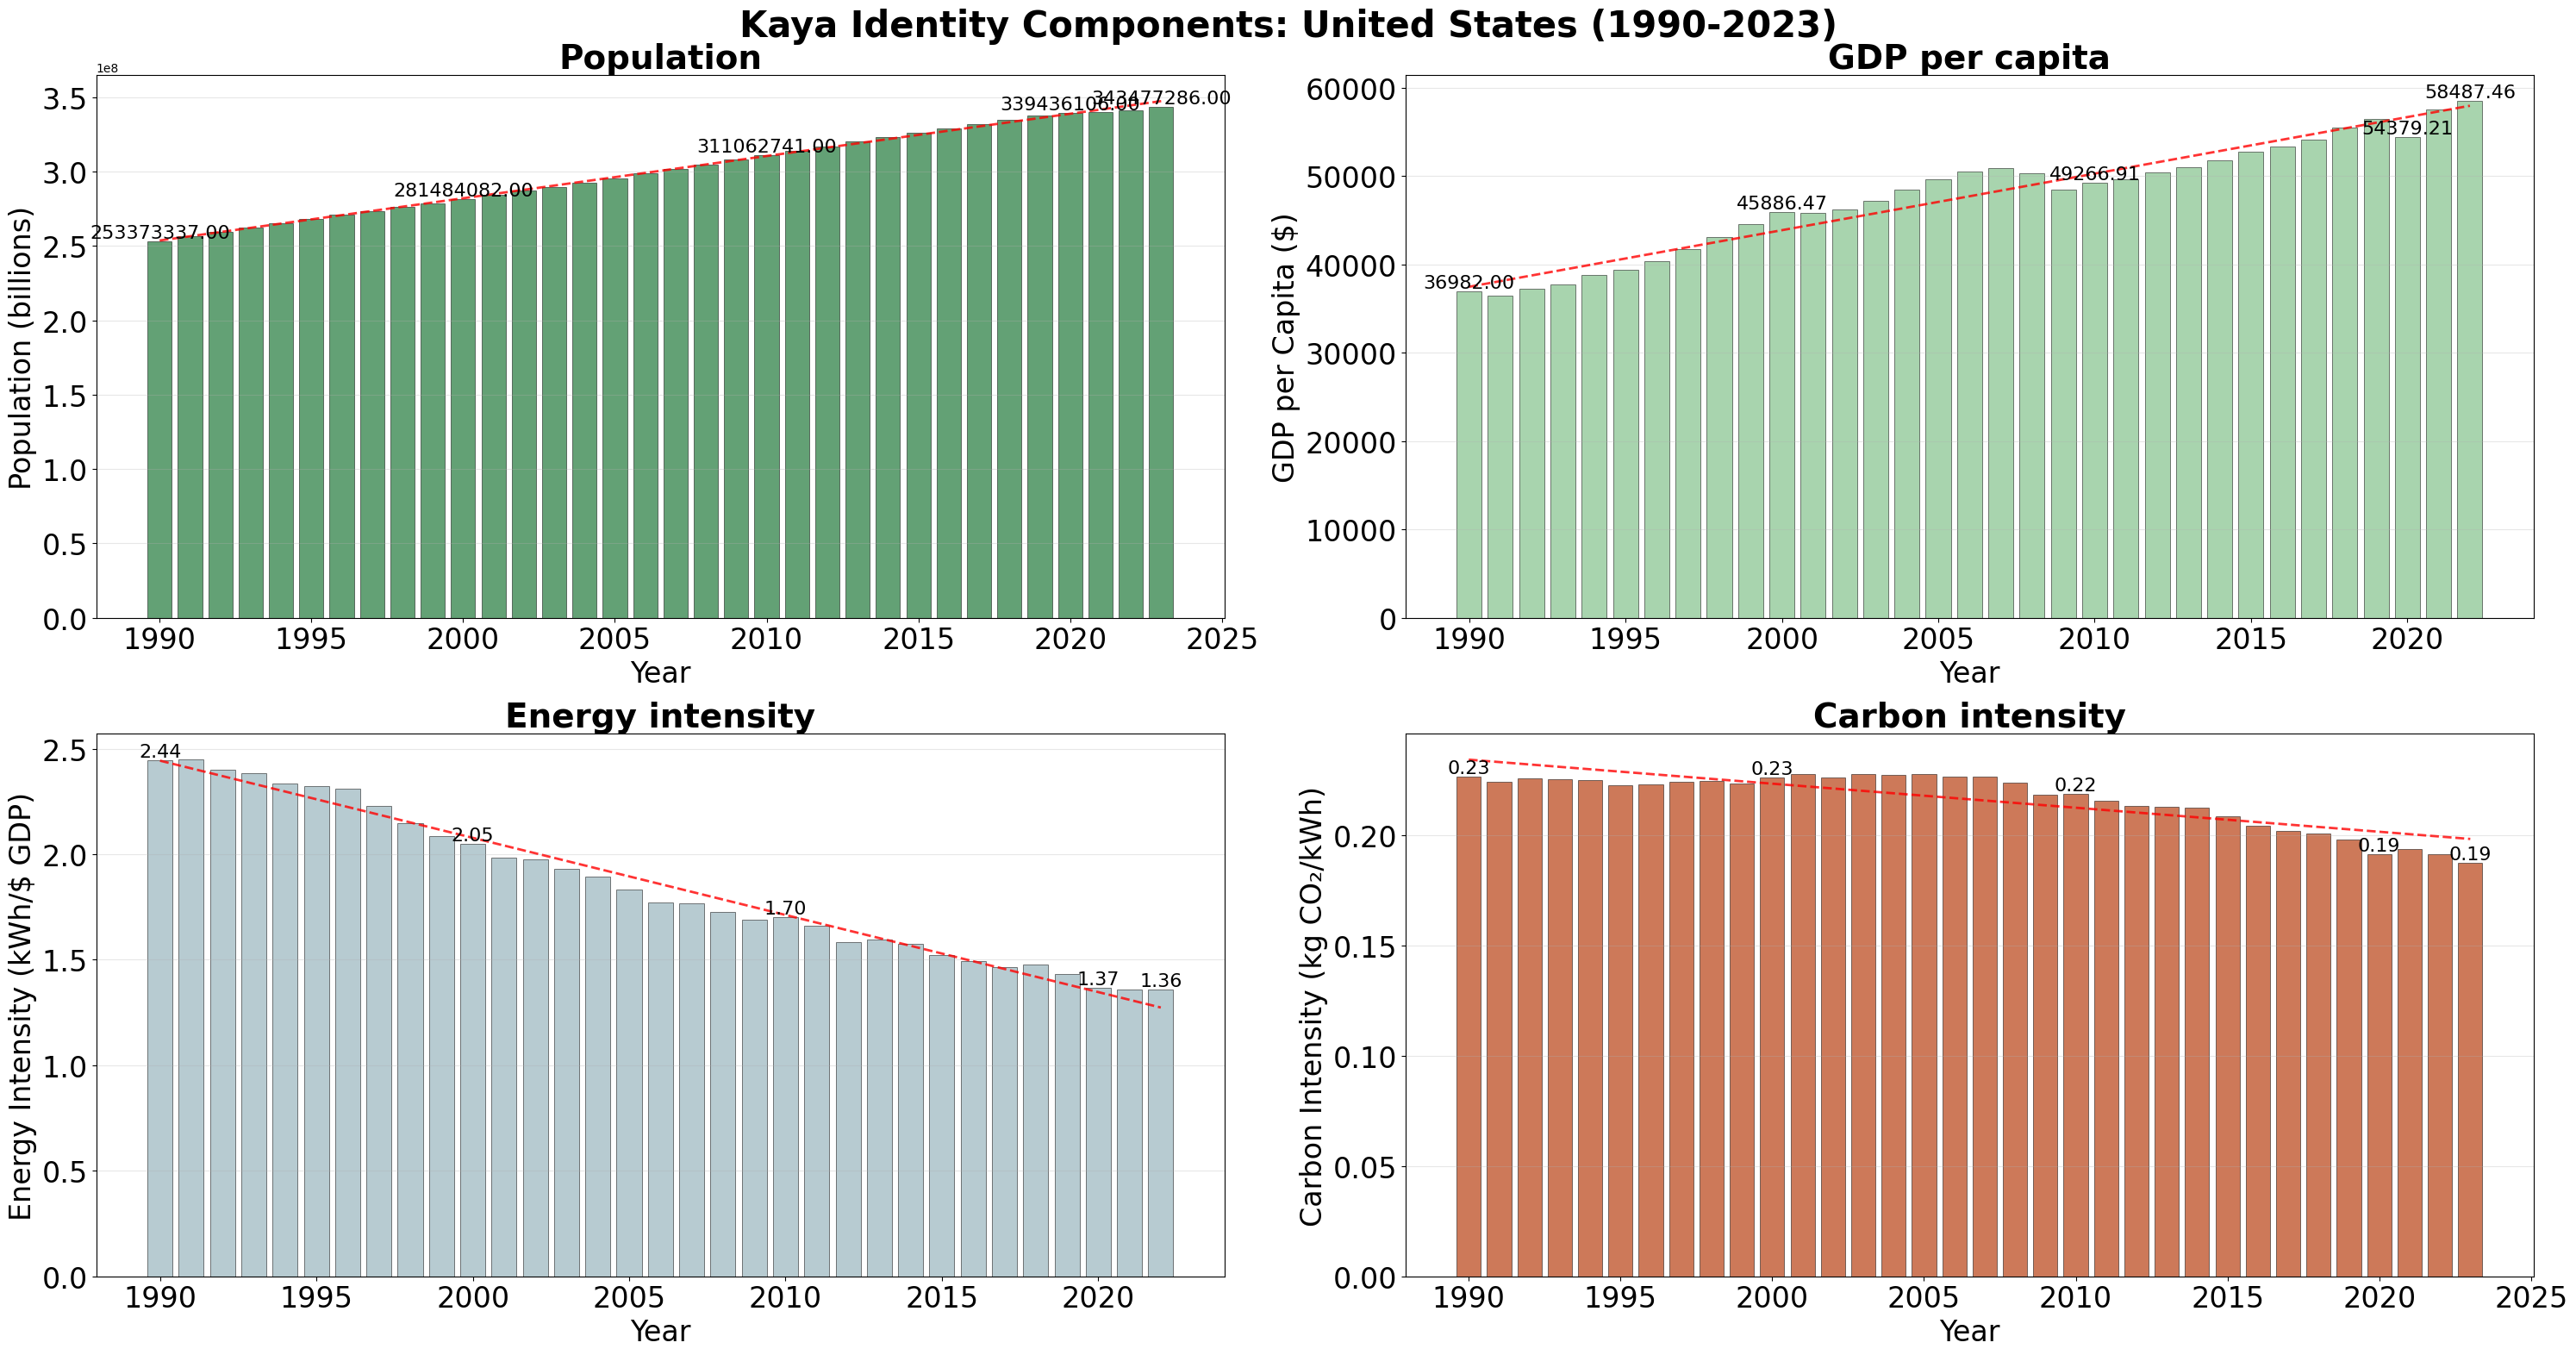


�� Summary Statistics for United States:

Population:
  • Start (1990): 253373337.00
  • End (2023): 343477286.00
  • Change: 35.6%
  • Average: 300597038.88
  • Std Dev: 28310359.19

GDP per capita:
  • Start (1990): 36982.00
  • End (2023): 58487.46
  • Change: 58.2%
  • Average: 47716.57
  • Std Dev: 6352.30

Energy intensity:
  • Start (1990): 2.44
  • End (2023): 1.36
  • Change: -44.4%
  • Average: 1.86
  • Std Dev: 0.36

Carbon intensity:
  • Start (1990): 0.23
  • End (2023): 0.19
  • Change: -17.2%
  • Average: 0.22
  • Std Dev: 0.01


In [28]:
# Cell 6: Example Charts
# Example: Create charts for specific regions
print("Example: World")
create_kaya_bar_charts('World')

print("\n" + "="*80 + "\n")
print("Example: United States")
create_kaya_bar_charts('United States')

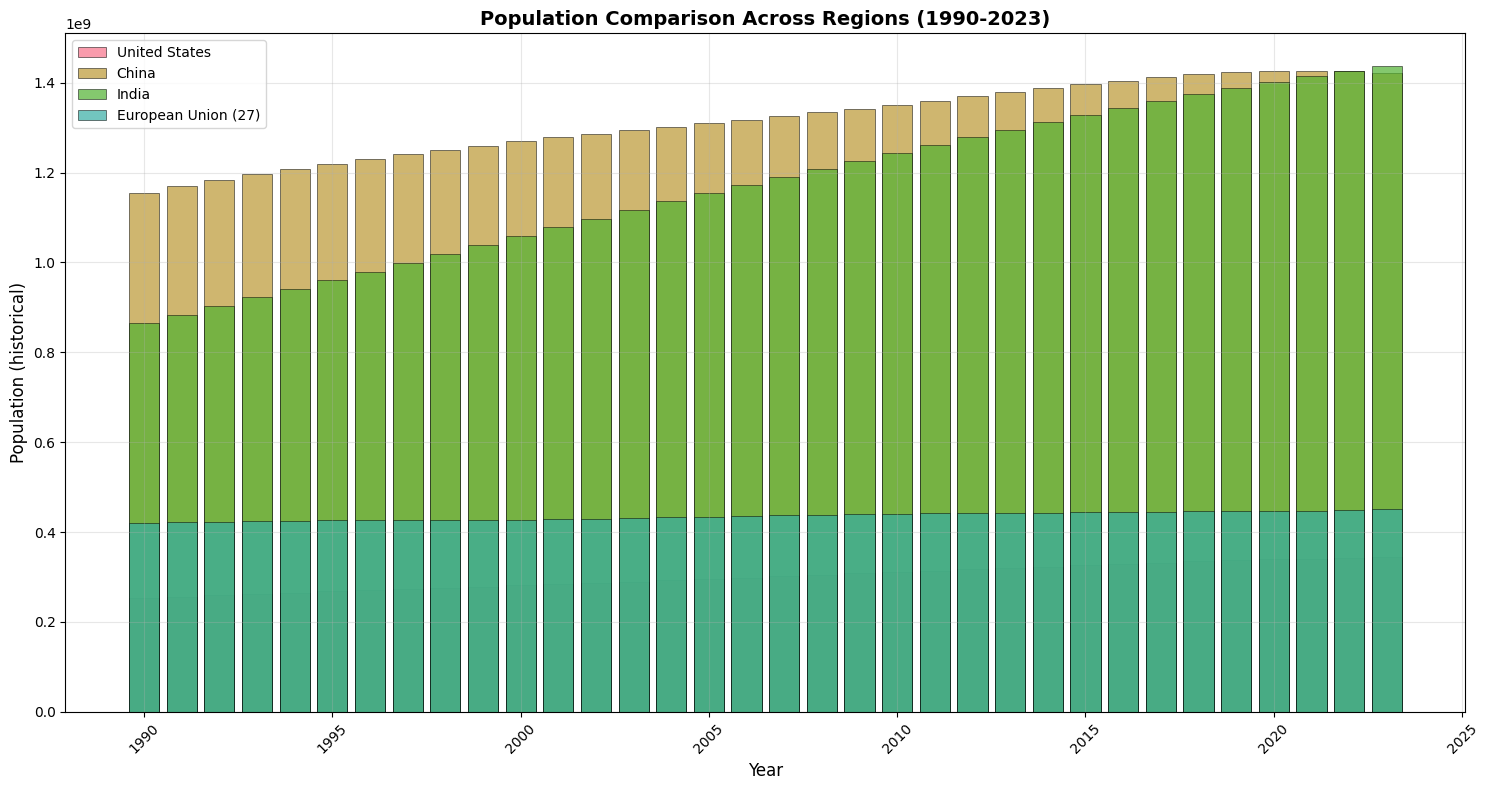

In [36]:
# Cell 7: Comparison Function
# Additional analysis: Compare multiple regions
def compare_regions_component(component_name, regions=['United States', 'China', 'India', 'European Union (27)']):
    """
    Compare a specific component across multiple regions.
    """
    
    components = {
        'Population': 'Population (historical)',
        'GDP per capita': 'GDP per capita',
        'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
        'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'
    }
    
    column_name = components[component_name]
    
    plt.figure(figsize=(15, 8))
    
    for region in regions:
        region_data = df_filtered[df_filtered['Entity'] == region].copy()
        if len(region_data) > 0:
            component_data = region_data[['Year', column_name]].dropna()
            if len(component_data) > 0:
                plt.bar(component_data['Year'], component_data[column_name], 
                       alpha=0.7, label=region, edgecolor='black', linewidth=0.5)
    
    plt.title(f'{component_name} Comparison Across Regions (1990-2023)', fontweight='bold', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example comparison
compare_regions_component('Population')

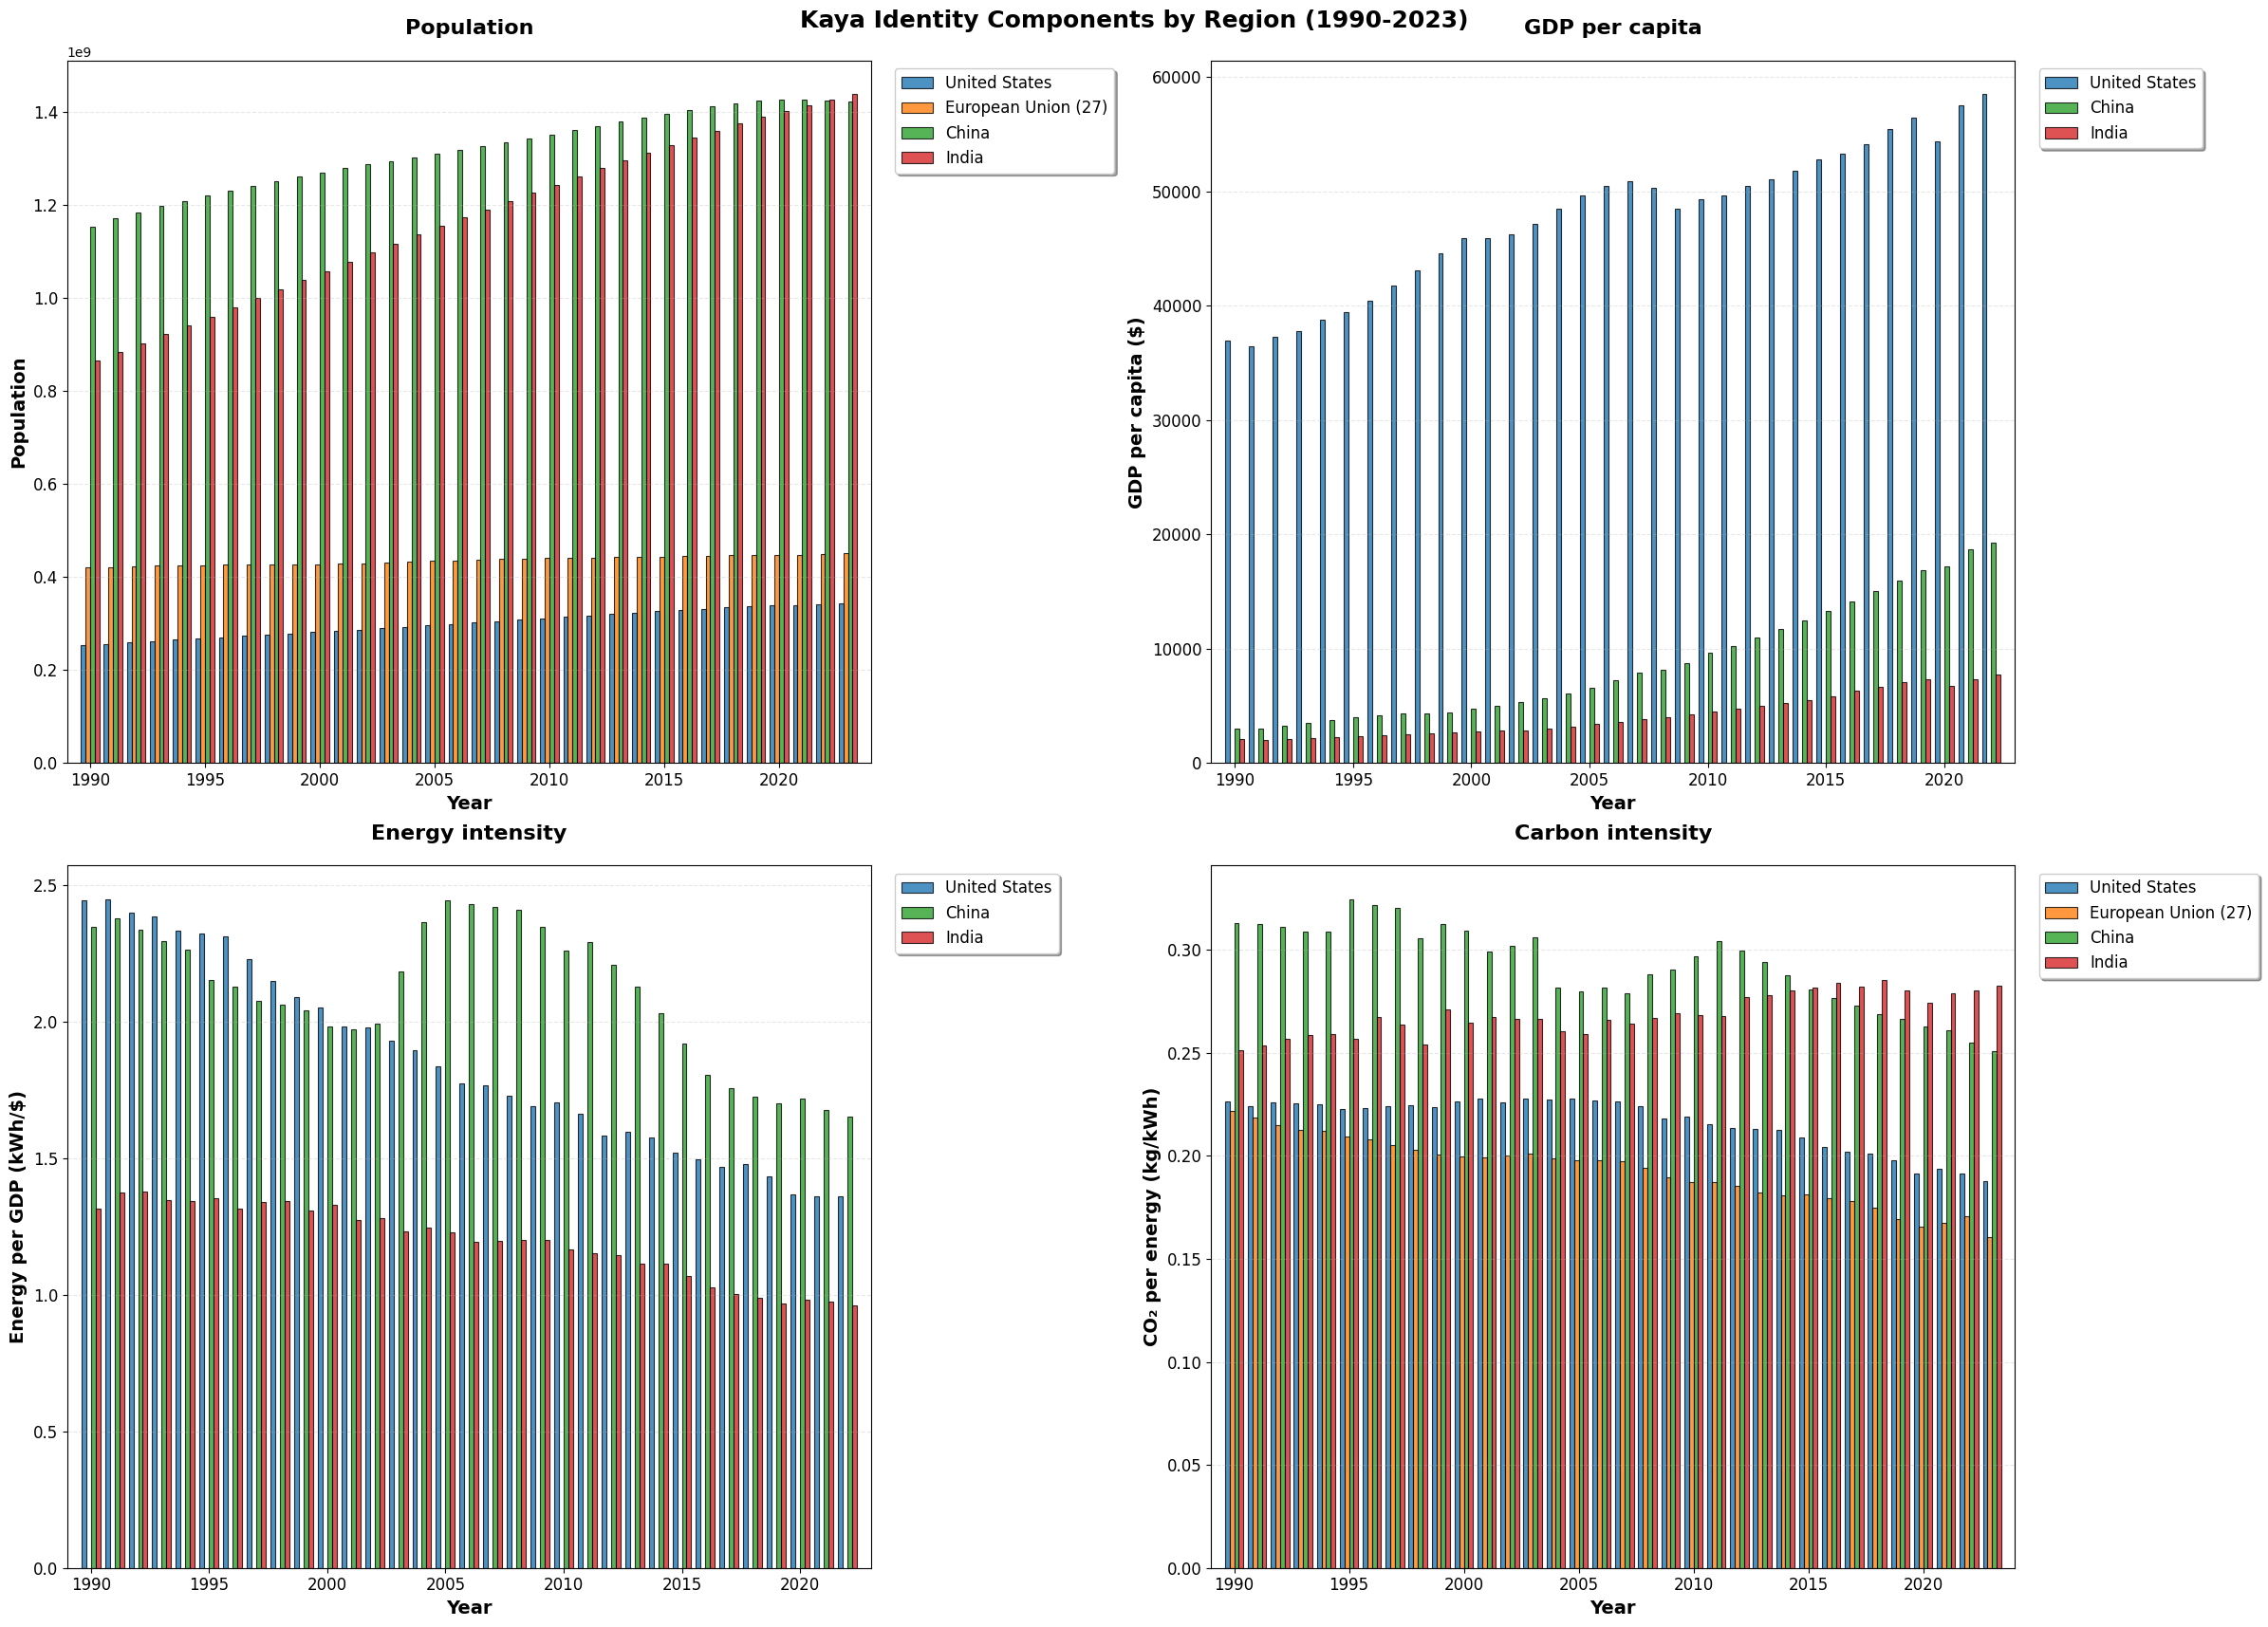


📊 Kaya Identity Summary for Selected Regions:

United States:
----------------------------------------


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [33]:
def plot_kaya_identity_bars(regions=['World', 'United States', 'China', 'India']):
    """
    Create bar plots showing the Kaya identity calculation for specified regions from 1990-2023.
    More readable version that handles missing data.
    
    Parameters:
    regions (list): List of region names to plot
    """
    
    # Define the components and their corresponding columns
    components = {
        'Population': 'Population (historical)',
        'GDP per capita': 'GDP per capita',
        'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
        'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'
    }
    
    # Create figure with more space
    fig, axes = plt.subplots(2, 2, figsize=(24, 18))
    fig.suptitle('Kaya Identity Components by Region (1990-2023)', fontsize=18, fontweight='bold', y=0.95)
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Better color palette for regions
    colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    for idx, (component_name, column_name) in enumerate(components.items()):
        ax = axes[idx]
        
        # Get all available years for this component across all regions
        all_years = set()
        for region in regions:
            region_data = df_filtered[df_filtered['Entity'] == region].copy()
            if len(region_data) > 0:
                component_data = region_data[['Year', column_name]].dropna()
                all_years.update(component_data['Year'].tolist())
        
        all_years = sorted(list(all_years))
        
        # Set bar width based on number of regions
        bar_width = 0.8 / len(regions)
        
        # Plot each region
        for i, region in enumerate(regions):
            region_data = df_filtered[df_filtered['Entity'] == region].copy()
            if len(region_data) > 0:
                component_data = region_data[['Year', column_name]].dropna()
                if len(component_data) > 0:
                    # Create bar chart for this region
                    x_positions = [year + (i - len(regions)/2 + 0.5) * bar_width for year in component_data['Year']]
                    bars = ax.bar(x_positions, component_data[column_name], 
                                 width=bar_width, alpha=0.8, label=region, 
                                 color=colors_list[i % len(colors_list)], 
                                 edgecolor='black', linewidth=0.8)
        
        # Customize the plot
        ax.set_title(f'{component_name}', fontweight='bold', fontsize=16, pad=20)
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        
        # Use shorter y-axis labels
        y_labels = {
            'Population': 'Population',
            'GDP per capita': 'GDP per capita ($)',
            'Energy intensity': 'Energy per GDP (kWh/$)',
            'Carbon intensity': 'CO₂ per energy (kg/kWh)'
        }
        ax.set_ylabel(y_labels[component_name], fontsize=14, fontweight='bold')
        
        # Improve x-axis
        ax.set_xticks(range(1990, 2024, 5))
        ax.set_xticklabels(range(1990, 2024, 5), fontsize=12)
        ax.tick_params(axis='x', rotation=0)  # No rotation for better readability
        
        # Improve y-axis
        ax.tick_params(axis='y', labelsize=12)
        
        # Add grid
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        
        # Add legend with better positioning
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, frameon=True, 
                 fancybox=True, shadow=True)
        
        # Set x-axis limits to show all data
        if all_years:
            ax.set_xlim(min(all_years) - 1, max(all_years) + 1)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust for title
    plt.show()
    
    # Print detailed summary for each region
    print(f"\n📊 Kaya Identity Summary for Selected Regions:")
    print("=" * 80)
    
    for region in regions:
        region_data = df_filtered[df_filtered['Entity'] == region].copy()
        if len(region_data) > 0:
            print(f"\n{region}:")
            print("-" * 40)
            
            for component_name, column_name in components.items():
                component_data = region_data[['Year', column_name]].dropna()
                if len(component_data) > 0:
                    start_val = component_data.iloc[0]
                    end_val = component_data.iloc[-1]
                    start_year = component_data['Year'].iloc[0]
                    end_year = component_data['Year'].iloc[-1]
                    
                    if start_val != 0:
                        change_pct = ((end_val - start_val) / start_val * 100)
                    else:
                        change_pct = 0
                    
                    print(f"  • {component_name}:")
                    print(f"    {start_year}: {start_val:.2f} → {end_year}: {end_val:.2f} ({change_pct:+.1f}%)")
                else:
                    print(f"  • {component_name}: No data available")

# Example usage with different region combinations
plot_kaya_identity_bars(['United States', 'European Union (27)', 'China', 'India'])



In [6]:
import pandas as pd
import numpy as np

# Load once if not already loaded
try:
    df
except NameError:
    df = pd.read_csv('kaya-identity-co2_1/kaya-identity-co2.csv')
    df.columns = df.columns.str.strip()

regions = ['World', 'United States', 'China', 'European Union (27)', 'India']
components = {
    'Population': 'Population (historical)',
    'GDP per capita': 'GDP per capita',
    'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
    'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'
}

def get_value_for_year(dataframe, region, year, column):
    sel = dataframe[(dataframe['Entity'] == region) & (dataframe['Year'] == year)]
    if sel.empty or column not in dataframe.columns:
        return np.nan
    try:
        return float(sel[column].iloc[0])
    except Exception:
        return np.nan

def get_latest_upto_year(dataframe, region, max_year, column):
    sel = dataframe[(dataframe['Entity'] == region) & (dataframe['Year'] <= max_year)][['Year', column]].dropna()
    if sel.empty:
        return np.nan, np.nan
    year_used = int(sel['Year'].max())
    val = sel.loc[sel['Year'] == year_used, column].iloc[0]
    try:
        return float(val), year_used
    except Exception:
        return np.nan, year_used

rows = []
for region in regions:
    for comp_name, col in components.items():
        v2019 = get_value_for_year(df, region, 2019, col)
        latest_val, latest_year = get_latest_upto_year(df, region, 2023, col)

        pct_change = np.nan
        if pd.notna(v2019) and pd.notna(latest_val) and v2019 != 0:
            pct_change = (latest_val - v2019) / v2019 * 100.0

        rows.append({
            'Region': region,
            'Component': comp_name,
            '2019 Value': v2019,
            'Latest Year (<=2023)': latest_year,
            'Latest Value': latest_val,
            '% Change since 2019': pct_change
        })

kaya_latest_vs_2019 = pd.DataFrame(rows)

# Optional formatting
def fmt_number(x):
    if pd.isna(x):
        return ''
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f}B'
    if abs(x) >= 1e6:
        return f'{x/1e6:.2f}M'
    if abs(x) >= 1e3:
        return f'{x/1e3:.2f}k'
    return f'{x:.2f}'

display(
    kaya_latest_vs_2019
      .assign(**{
          '2019 Value': kaya_latest_vs_2019['2019 Value'].map(fmt_number),
          'Latest Value': kaya_latest_vs_2019['Latest Value'].map(fmt_number),
          '% Change since 2019': kaya_latest_vs_2019['% Change since 2019'].map(lambda x: '' if pd.isna(x) else f'{x:+.1f}%')
      })
      .sort_values(['Region', 'Component'])
      .reset_index(drop=True)
)

,Region,Component,2019 Value,Latest Year (<=2023),Latest Value,% Change since 2019
0,China,Carbon intensity,0.27,2023,0.25,-5.9%
1,China,Energy intensity,1.70,2022,1.65,-2.9%
2,China,GDP per capita,16.88k,2022,19.24k,+14.0%
3,China,Population,1.42B,2023,1.42B,-0.1%
4,European Union (27),Carbon intensity,0.17,2023,0.16,-5.1%
5,European Union (27),Energy intensity,1.04,2022,0.95,-8.7%
6,European Union (27),GDP per capita,37.21k,2022,38.05k,+2.3%
7,European Union (27),Population,447.37M,2023,450.66M,+0.7%
8,India,Carbon intensity,0.28,2023,0.28,+0.8%
9,India,Energy intensity,0.97,2022,0.96,-0.7%


In [5]:
import numpy as np
import pandas as pd

EU27_MEMBERS = [
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland',
    'France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Lithuania','Luxembourg',
    'Malta','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia','Spain','Sweden'
]

COL_POP = 'Population (historical)'
COL_GDP_PC = 'GDP per capita'
COL_ENERGY_PER_GDP = 'Primary energy consumption per GDP (kWh/$)'
COL_EMISSIONS = 'Annual CO₂ emissions'
COL_CI = 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'

def compute_eu27_aggregates_from_members(df, eu_name='European Union (27)'):
    cols_needed = ['Entity','Year',COL_POP,COL_GDP_PC,COL_ENERGY_PER_GDP,COL_EMISSIONS]
    cols_present = [c for c in cols_needed if c in df.columns]
    d = df[cols_present].copy()

    for c in [COL_POP, COL_GDP_PC, COL_ENERGY_PER_GDP, COL_EMISSIONS]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors='coerce')

    members = d[d['Entity'].isin(EU27_MEMBERS)].copy()
    if members.empty:
        return pd.DataFrame(columns=df.columns)

    members['total_gdp'] = np.where(
        members[[COL_GDP_PC, COL_POP]].notna().all(axis=1),
        members[COL_GDP_PC] * members[COL_POP],
        np.nan
    )
    if COL_ENERGY_PER_GDP in members.columns:
        members['total_primary_energy'] = np.where(
            members[['total_gdp', COL_ENERGY_PER_GDP]].notna().all(axis=1),
            members['total_gdp'] * members[COL_ENERGY_PER_GDP],
            np.nan
        )

    agg_dict = {COL_POP:'sum','total_gdp':'sum'}
    if 'total_primary_energy' in members.columns: agg_dict['total_primary_energy'] = 'sum'
    if COL_EMISSIONS in members.columns: agg_dict[COL_EMISSIONS] = 'sum'

    agg = members.groupby('Year', as_index=False).agg(agg_dict).rename(columns={
        COL_POP:'eu_pop',
        'total_gdp':'eu_gdp',
        'total_primary_energy':'eu_primary_energy',
        COL_EMISSIONS:'eu_emissions'
    })

    out = pd.DataFrame({'Year': agg['Year'], 'Entity': eu_name, 'Code': 'EU27C'})
    out[COL_POP] = agg['eu_pop']
    out[COL_GDP_PC] = np.where((agg['eu_gdp'] > 0) & (agg['eu_pop'] > 0), agg['eu_gdp'] / agg['eu_pop'], np.nan)
    if 'eu_primary_energy' in agg.columns and 'eu_gdp' in agg.columns:
        out[COL_ENERGY_PER_GDP] = np.where(
            (agg['eu_primary_energy'] > 0) & (agg['eu_gdp'] > 0),
            agg['eu_primary_energy'] / agg['eu_gdp'],
            np.nan
        )
    if (COL_CI in df.columns) and ('eu_emissions' in agg.columns) and ('eu_primary_energy' in agg.columns):
        out[COL_CI] = np.where(
            (agg['eu_emissions'] > 0) & (agg['eu_primary_energy'] > 0),
            agg['eu_emissions'] / agg['eu_primary_energy'],
            np.nan
        )

    keep_cols = [c for c in df.columns if c in out.columns]
    return out[keep_cols].copy()

eu_computed = compute_eu27_aggregates_from_members(df)
if not eu_computed.empty:
    eu_mask = df['Entity'] == 'European Union (27)'
    eu_df = df[eu_mask].copy()
    non_eu_df = df[~eu_mask].copy()

    right_cols = [c for c in eu_computed.columns if c not in ['Entity','Code','Year']]
    merged = eu_df.merge(
        eu_computed[['Year'] + right_cols],  # Year only once (merge key)
        on='Year',
        how='outer',
        suffixes=('', '_computed')
    )

    for col in [COL_POP, COL_GDP_PC, COL_ENERGY_PER_GDP, COL_CI]:
        if (col in merged.columns) and (f'{col}_computed' in merged.columns):
            merged[col] = merged[col].combine_first(merged[f'{col}_computed'])

    merged = merged[[c for c in merged.columns if not c.endswith('_computed')]]
    merged = merged.loc[:, ~merged.columns.duplicated()]  # ensure uniqueness

    df = pd.concat([non_eu_df, merged], ignore_index=True)
    df = df.loc[:, ~df.columns.duplicated()]  # final dedupe
    print('Filled EU27 missing values for GDP per capita and Energy intensity where possible.')
else:
    print('EU27 computed aggregates are empty (likely missing member inputs).')

Filled EU27 missing values for GDP per capita and Energy intensity where possible.


In [7]:
import pandas as pd
import numpy as np

# Load once if not already loaded
try:
    df
except NameError:
    df = pd.read_csv('kaya-identity-co2_1/kaya-identity-co2.csv')
    df.columns = df.columns.str.strip()
    df = df.loc[:, ~df.columns.duplicated()]

regions = ['World', 'United States', 'China', 'European Union (27)', 'India']

components = {
    'Population': 'Population (historical)',
    'GDP per capita': 'GDP per capita',
    'Energy intensity': 'Primary energy consumption per GDP (kWh/$)',
    'Carbon intensity': 'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)',
    'CO₂ emissions': 'Annual CO₂ emissions'
}

def get_value_for_year(dataframe, region, year, column):
    sel = dataframe[(dataframe['Entity'] == region) & (dataframe['Year'] == year)]
    if sel.empty or column not in dataframe.columns:
        return np.nan
    try:
        return float(sel[column].iloc[0])
    except Exception:
        return np.nan

def get_latest_upto_year(dataframe, region, max_year, column):
    sel = dataframe[(dataframe['Entity'] == region) & (dataframe['Year'] <= max_year)][['Year', column]].dropna()
    if sel.empty:
        return np.nan, np.nan
    year_used = int(sel['Year'].max())
    val = sel.loc[sel['Year'] == year_used, column].iloc[0]
    try:
        return float(val), year_used
    except Exception:
        return np.nan, year_used

rows = []
for region in regions:
    for comp_name, col in components.items():
        v2019 = get_value_for_year(df, region, 2019, col)
        latest_val, latest_year = get_latest_upto_year(df, region, 2023, col)

        pct_change = np.nan
        if pd.notna(v2019) and pd.notna(latest_val) and v2019 != 0:
            pct_change = (latest_val - v2019) / v2019 * 100.0

        rows.append({
            'Region': region,
            'Component': comp_name,
            '2019 Value': v2019,
            'Latest Year (<=2023)': latest_year,
            'Latest Value': latest_val,
            '% Change since 2019': pct_change
        })

kaya_latest_vs_2019 = pd.DataFrame(rows)

# Optional formatting
def fmt_number(x):
    if pd.isna(x):
        return ''
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f}B'
    if abs(x) >= 1e6:
        return f'{x/1e6:.2f}M'
    if abs(x) >= 1e3:
        return f'{x/1e3:.2f}k'
    return f'{x:.2f}'

display(
    kaya_latest_vs_2019
      .assign(**{
          '2019 Value': kaya_latest_vs_2019['2019 Value'].map(fmt_number),
          'Latest Value': kaya_latest_vs_2019['Latest Value'].map(fmt_number),
          '% Change since 2019': kaya_latest_vs_2019['% Change since 2019'].map(lambda x: '' if pd.isna(x) else f'{x:+.1f}%')
      })
      .sort_values(['Region', 'Component'])
      .reset_index(drop=True)
)

,Region,Component,2019 Value,Latest Year (<=2023),Latest Value,% Change since 2019
0,China,CO₂ emissions,10.71B,2023,11.90B,+11.1%
1,China,Carbon intensity,0.27,2023,0.25,-5.9%
2,China,Energy intensity,1.70,2022,1.65,-2.9%
3,China,GDP per capita,16.88k,2022,19.24k,+14.0%
4,China,Population,1.42B,2023,1.42B,-0.1%
5,European Union (27),CO₂ emissions,2.90B,2023,2.51B,-13.6%
6,European Union (27),Carbon intensity,0.17,2023,0.16,-5.1%
7,European Union (27),Energy intensity,1.04,2022,0.95,-8.7%
8,European Union (27),GDP per capita,37.21k,2022,38.05k,+2.3%
9,European Union (27),Population,447.37M,2023,450.66M,+0.7%


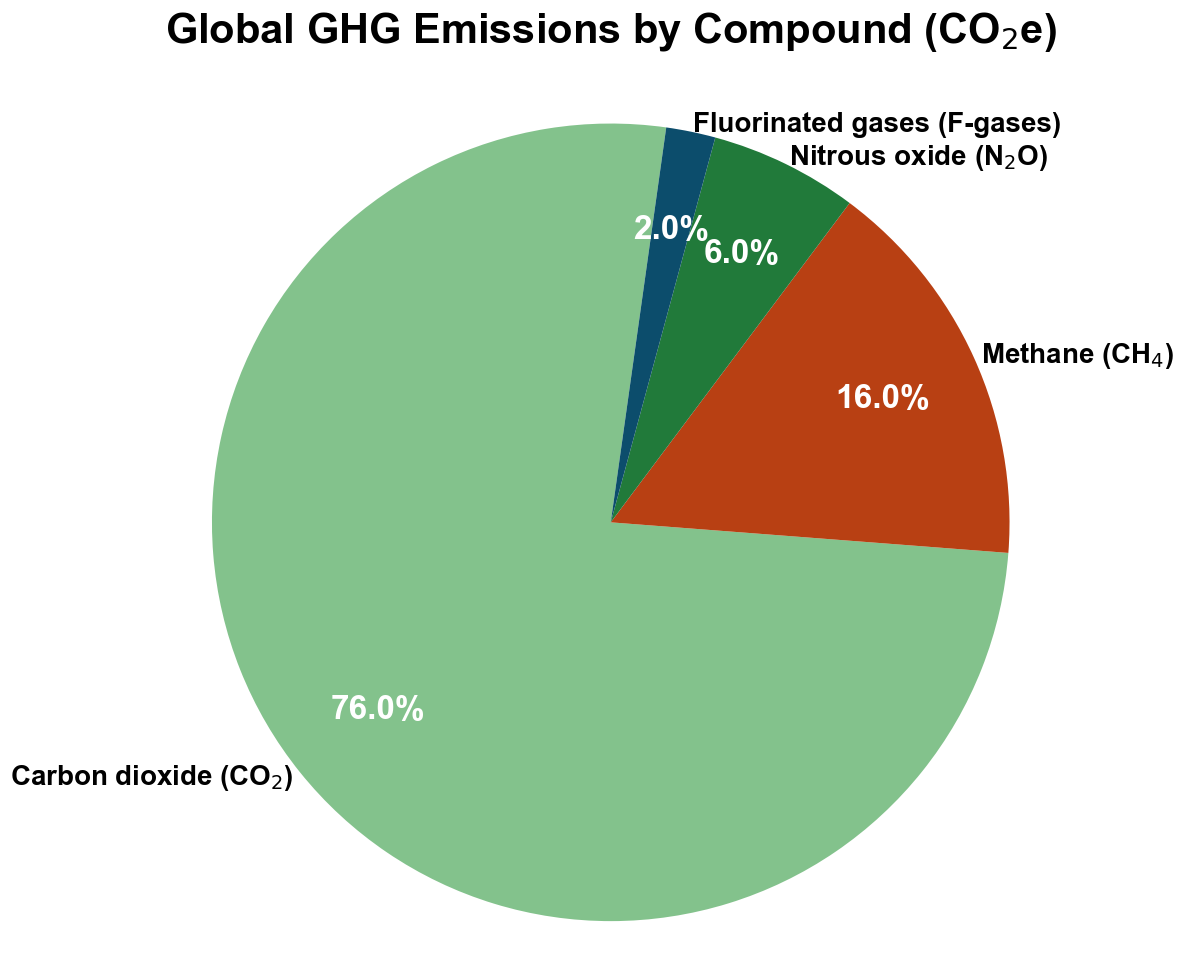

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Data
compounds = ['Carbon dioxide (CO$_2$)', 'Methane (CH$_4$)', 'Nitrous oxide (N$_2$O)', 'Fluorinated gases (F-gases)']
percentages = [76, 16, 6, 2]

# Colors from your notebook
colors = [lightgreen, burntorange, green, darkblueteal]

# Create pie chart
fig, ax = plt.subplots(figsize=(12, 10))
wedges, texts, autotexts = ax.pie(percentages, labels=compounds, colors=colors, autopct='%1.1f%%',
                                  startangle=82, textprops={'fontsize': 20, 'fontweight': 'bold'},
                                  pctdistance=0.75, labeldistance=1.02)
# Customize the chart
ax.set_title('Global GHG Emissions by Compound (CO$_2$e)', fontsize=30, fontweight='bold', pad=30)

# Make percentage text bold and larger
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(24)
    autotext.set_fontweight('bold')

# Add a legend
# ax.legend(wedges, [f'{comp} ({pct}%)' for comp, pct in zip(compounds, percentages)],
        #   title="Greenhouse Gases",
        #   loc="center left",
        #   bbox_to_anchor=(1, 0, 0.5, 1),
        #   fontsize=11)

# Ensure the pie chart is circular
ax.axis('equal')

plt.tight_layout()
plt.show()

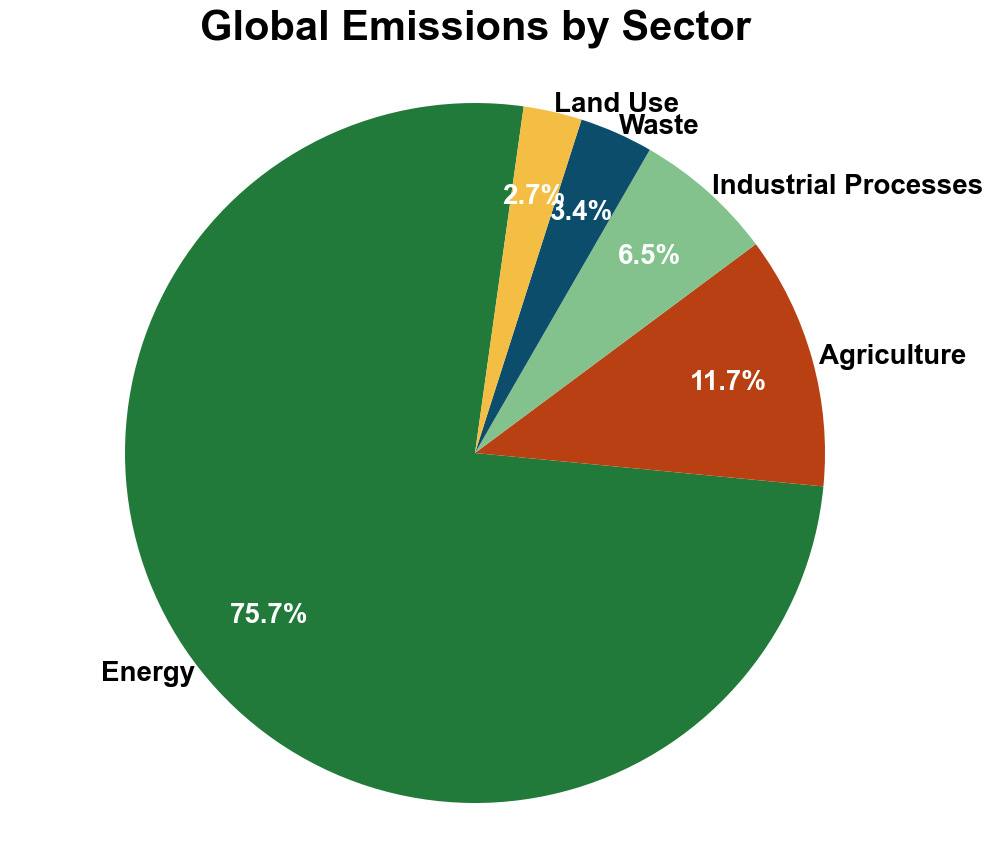

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
sectors = ['Energy', 'Agriculture', 'Industrial Processes', 'Waste', 'Land Use']
percentages = [75.7, 11.7, 6.5, 3.4, 2.7]

# Colors (extended from your notebook colors to include 5 distinct colors)
colors = [green, burntorange, lightgreen, darkblueteal, yellowmustard]  # Blue, Purple, Orange, Red, Green

# Create pie chart
fig, ax = plt.subplots(figsize=(12, 10))
wedges, texts, autotexts = ax.pie(percentages, labels=sectors, colors=colors, autopct='%1.1f%%',
                                  startangle=82, textprops={'fontsize': 20, 'fontweight': 'bold'},
                                  pctdistance=0.75, labeldistance=1.02)
# Customize the chart
ax.set_title('Global Emissions by Sector', fontsize=30, fontweight='bold', pad=20)

# Make percentage text white for better contrast on darker slices
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(20)
    autotext.set_fontweight('bold')

# Add a legend
# ax.legend(wedges, [f'{sector} ({pct}%)' for sector, pct in zip(sectors, percentages)],
#           title="Sectors",
#           loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 1),
#           fontsize=11)

# Ensure the pie chart is circular
ax.axis('equal')

# plt.tight_layout()
plt.show()


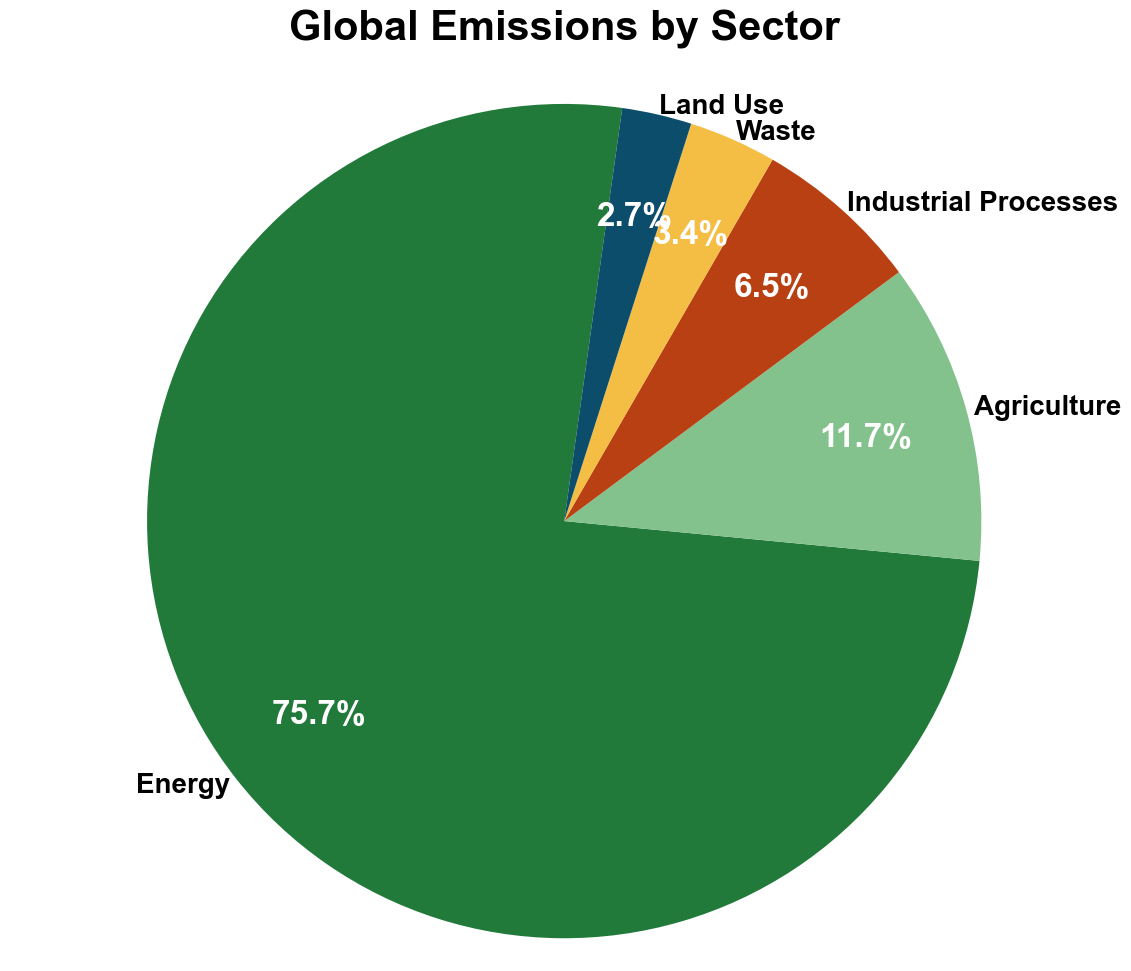

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
sectors = ['Energy', 'Agriculture', 'Industrial Processes', 'Waste', 'Land Use']
percentages = [75.7, 11.7, 6.5, 3.4, 2.7]

# Your requested color scheme
colors = [green, lightgreen, burntorange, yellowmustard, darkblueteal]

# Create pie chart
fig, ax = plt.subplots(figsize=(12, 10))
wedges, texts, autotexts = ax.pie(percentages, labels=sectors, colors=colors, autopct='%1.1f%%',
                                  startangle=82, textprops={'fontsize': 20, 'fontweight': 'bold'},
                                  pctdistance=0.75, labeldistance=1.02)

# Customize the chart
ax.set_title('Global Emissions by Sector', fontsize=30, fontweight='bold', pad=30)

# Make percentage text white for better contrast
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(24)
    autotext.set_fontweight('bold')

# Ensure the pie chart is circular
ax.axis('equal')

plt.tight_layout()
plt.show()